# Imports e Instalações

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
!pip install boruta
!pip install inflection
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from mpl_toolkits.mplot3d import Axes3D
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy import stats
from boruta import BorutaPy
import inflection
from sklearn.ensemble import RandomForestRegressor
import math
import zipfile

%matplotlib inline

from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/desafio-dp6

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/desafio-dp6


# **PARTE 1** - Limpeza dos dados

De acordo com o link abaixo, a estrutura de organização dos scopes das tabelas deve ser a seguinte: sessions contêm hits, que contêm products. Portanto, os joins serão feitos seguindo esta lógica.

Em resumo, sessions são um conjunto de um ou mais hits em um determinado intervalo de tempo; hits são as interações que ocorrem no e-commerce; e products são os produtos.

https://www.bounteous.com/insights/2016/11/30/understanding-scope-google-analytics-reporting/

In [9]:
with zipfile.ZipFile('sessions.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [11]:
with zipfile.ZipFile('hits.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [13]:
with zipfile.ZipFile('products.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

## Sessions

In [14]:
# carregando tabela sessions
sessions_dtypes = {
    'date': str,
    'fullVisitorId': str,
    'visitId': str
}
sessions = pd.read_csv('./data/sessions.csv', dtype=sessions_dtypes)

In [ ]:
sessions.dtypes

channelGrouping                      object
date                                 object
fullVisitorId                        object
socialEngagementType                 object
visitId                              object
visitNumber                           int64
visitStartTime                        int64
salesRegion                          object
device_mobileDeviceMarketingName     object
device_screenColors                  object
device_deviceCategory                object
device_flashVersion                  object
device_mobileDeviceBranding          object
device_mobileDeviceModel             object
device_screenResolution              object
device_mobileDeviceInfo              object
device_language                      object
device_browserSize                   object
device_browser                       object
device_operatingSystemVersion        object
device_browserVersion                object
device_operatingSystem               object
device_mobileInputSelector      

In [ ]:
sessions.duplicated().sum()

0

In [ ]:
sessions.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
channelGrouping,73948,8,Organic Search,31774,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,73948,638,20171212,420,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fullVisitorId,73948,57294,3269834865385146569,157,NaN,NaN,NaN,NaN,NaN,NaN,NaN
socialEngagementType,73948,1,Not Socially Engaged,73948,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visitId,73948,73749,1513124962,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visitNumber,73948.0,NaN,NaN,NaN,2.283699,7.77794,1.0,1.0,1.0,1.0,185.0
visitStartTime,73948.0,NaN,NaN,NaN,1498346661.786837,16188752.203702,1470035832.0,1482858070.0,1499889933.5,1512433560.5,1525156929.0
salesRegion,59527,5,North America,33503,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device_mobileDeviceMarketingName,73948,1,not available in demo dataset,73948,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device_screenColors,73948,1,not available in demo dataset,73948,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# removendo colunas que tem uma única variação de valor em todas as 73948 linhas
colunas_sessions_remover = sessions.describe(include='all').T.reset_index()
colunas_sessions_remover = colunas_sessions_remover[colunas_sessions_remover.unique == 1][colunas_sessions_remover.freq == 73948]
colunas_sessions_remover = list(colunas_sessions_remover['index'])

sessions_filt = sessions.drop(columns=colunas_sessions_remover)

In [ ]:
# quantos visitantes existem?
len(sessions_filt.fullVisitorId.unique())

57294

Como é a distribuição dos dados dos 50 visitantes mais frequentes?

In [ ]:
# quem são eles
mais_frequentes = pd.DataFrame(sessions_filt.groupby('fullVisitorId').sum()['totals_transactions'], columns=['totals_transactions'])
mais_frequentes.reset_index(inplace=True)
mais_frequentes.sort_values(by='totals_transactions', ascending=False, inplace=True)
mais_frequentes_lista = mais_frequentes[0:50]['fullVisitorId']
mais_frequentes_lista

mais_frequentes_df = sessions_filt[sessions_filt.fullVisitorId.isin(mais_frequentes_lista) == True]
mais_frequentes_df

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,salesRegion,device_deviceCategory,device_browser,device_operatingSystem,...,totals_sessionQualityDim,totals_visits,totals_transactionRevenue,trafficSource_adContent,trafficSource_campaign,trafficSource_source,trafficSource_referralPath,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium
322,Organic Search,20171130,7445235885559107095,1512076535,149,1512076535,North America,desktop,Internet Explorer,Windows,...,1.0,1,NaN,NaN,(not set),google,NaN,True,(not provided),organic
339,Referral,20171130,2904329822175970539,1512063653,15,1512063653,North America,desktop,Chrome,Macintosh,...,2.0,1,NaN,NaN,(not set),(direct),/,True,NaN,(none)
451,Referral,20170126,3835134197841326255,1485447889,5,1485447889,North America,desktop,Chrome,Macintosh,...,NaN,1,NaN,NaN,(not set),(direct),/,NaN,NaN,(none)
527,Direct,20170623,4116720743881459837,1498235712,23,1498235712,North America,desktop,Chrome,Macintosh,...,NaN,1,NaN,NaN,(not set),(direct),NaN,True,NaN,(none)
662,Direct,20170203,1814166460229302850,1486135601,8,1486135601,North America,desktop,Chrome,Chrome OS,...,NaN,1,1.171470e+09,NaN,(not set),(direct),NaN,True,NaN,(none)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73098,Referral,20170811,5784496448856155570,1502484164,6,1502484164,North America,desktop,Chrome,Macintosh,...,4.0,1,NaN,NaN,(not set),(direct),/,True,NaN,(none)
73620,Direct,20180209,603935369785924594,1518209344,157,1518209344,North America,desktop,Chrome,Windows,...,3.0,1,NaN,NaN,(not set),(direct),NaN,True,NaN,(none)
73644,Direct,20180209,7445235885559107095,1518208744,178,1518208744,North America,desktop,Internet Explorer,Windows,...,1.0,1,NaN,NaN,(not set),(direct),NaN,True,NaN,(none)
73862,Display,20170104,7445235885559107095,1483548480,10,1483548480,North America,desktop,Internet Explorer,Windows,...,NaN,1,NaN,NaN,(not set),dfa,NaN,True,NaN,cpm


Text(0.5, 1.0, 'Receita dos 50 clientes que mais gastaram')

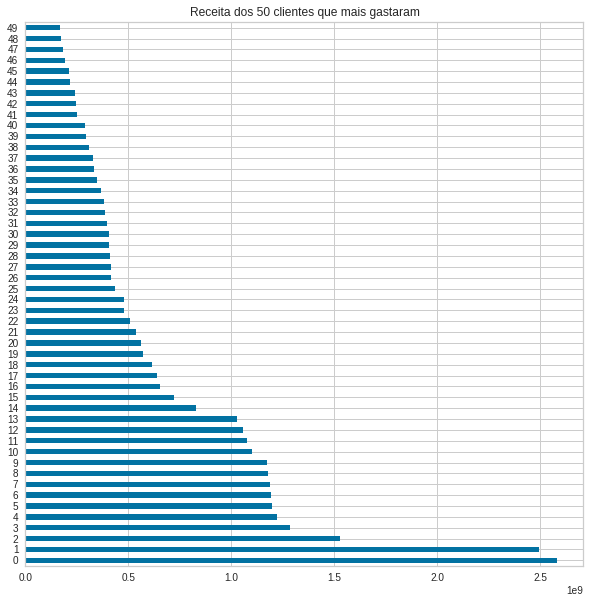

In [ ]:
# em relação ao total de receita
df_total_receita = mais_frequentes_df[['fullVisitorId', 'totals_totalTransactionRevenue']]
df_total_receita.sort_values(by=['totals_totalTransactionRevenue'], ascending=False, inplace=True)
df_total_receita.reset_index(inplace=True)
plt.figure(figsize=(10,10))
df_total_receita.totals_totalTransactionRevenue[0:50].plot(kind='barh')
plt.title('Receita dos 50 clientes que mais gastaram')

Text(0.5, 1.0, 'Total de transações dos 50 clientes que mais compraram')

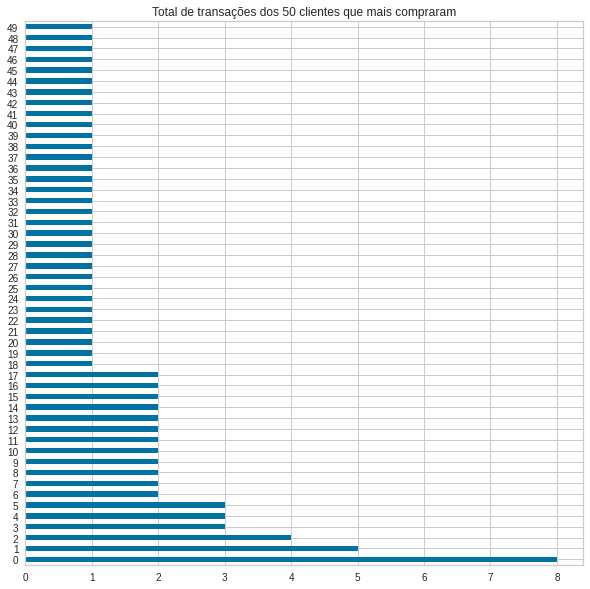

In [ ]:
# em relação ao total de transacoes
df_total_transacoes = mais_frequentes_df[['fullVisitorId', 'totals_transactions']]
df_total_transacoes.sort_values(by=['totals_transactions'], ascending=False, inplace=True)
df_total_transacoes.reset_index(inplace=True)
plt.figure(figsize=(10,10))
df_total_transacoes.totals_transactions[0:50].plot(kind='barh')
plt.title('Total de transações dos 50 clientes que mais compraram')

In [ ]:
# criando coluna com uniqueVisitorSessionId
def concat_strings(string1, string2):
  return string1+string2

sessions_df = sessions_filt.copy()
sessions_df['uniqueVisitorSessionId'] = sessions_df.apply(lambda x: concat_strings(x['fullVisitorId'], x['visitId']), axis=1)

sessions_df.uniqueVisitorSessionId.value_counts()

8744244054939210151510386987     2
12336453773740602671516693612    2
18017136809191517381470207133    2
95490898520953789571511682939    2
92882807369689436361486367962    2
                                ..
76818167188227186211519750736    1
86524742516133487731519724436    1
1505956114016316311519758258     1
67345233549167925381519756978    1
12650103553415385091483548229    1
Name: uniqueVisitorSessionId, Length: 73874, dtype: int64

In [ ]:
# algumas sessions começam em um dia e se estendem até outro, e por isso o uniqueId fica repetido
sessions_df[sessions_df.uniqueVisitorSessionId == '62365610805185719481513324735']

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,salesRegion,device_deviceCategory,device_browser,device_operatingSystem,...,totals_visits,totals_transactionRevenue,trafficSource_adContent,trafficSource_campaign,trafficSource_source,trafficSource_referralPath,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,uniqueVisitorSessionId
24475,Direct,20171215,6236561080518571948,1513324735,1,1513324801,North America,mobile,Chrome,Android,...,1,NaN,NaN,(not set),(direct),NaN,True,NaN,(none),62365610805185719481513324735
37617,Direct,20171214,6236561080518571948,1513324735,1,1513324735,North America,mobile,Chrome,Android,...,1,NaN,NaN,(not set),(direct),NaN,True,NaN,(none),62365610805185719481513324735


### Sessões conversoras

In [ ]:
sessions_conv = sessions_df[sessions_df.totals_transactions.isnull() == False]
sessions_conv

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,salesRegion,device_deviceCategory,device_browser,device_operatingSystem,...,totals_visits,totals_transactionRevenue,trafficSource_adContent,trafficSource_campaign,trafficSource_source,trafficSource_referralPath,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,uniqueVisitorSessionId
24,Organic Search,20171016,4716737341148415941,1508185536,1,1508185536,North America,tablet,Internet Explorer,Windows,...,1,42000000.0,NaN,(not set),google,NaN,NaN,(not provided),organic,47167373411484159411508185536
26,Referral,20171016,9291001063810206156,1508190255,3,1508190255,North America,desktop,Chrome,Chrome OS,...,1,9120000.0,NaN,(not set),(direct),/,NaN,NaN,(none),92910010638102061561508190255
292,Referral,20171130,9851027407827249742,1512059036,1,1512059036,North America,desktop,Chrome,Macintosh,...,1,44580000.0,NaN,(not set),(direct),/,NaN,NaN,(none),98510274078272497421512059036
293,Organic Search,20171130,9549089852095378957,1512072523,5,1512072523,North America,tablet,Safari,iOS,...,1,85430000.0,NaN,(not set),google,NaN,True,(not provided),organic,95490898520953789571512072523
543,Referral,20170623,750845334721949296,1498226004,1,1498226004,North America,desktop,Chrome,Macintosh,...,1,298760000.0,NaN,(not set),(direct),/,NaN,NaN,(none),7508453347219492961498226004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72912,Organic Search,20180216,805494030813869156,1518842890,1,1518842890,North America,desktop,Chrome,Windows,...,1,15240000.0,NaN,(not set),google,NaN,NaN,(not provided),organic,8054940308138691561518842890
73022,Direct,20170811,5495308280409652712,1502485898,1,1502485898,North America,desktop,Chrome,Linux,...,1,22800000.0,NaN,(not set),(direct),NaN,True,NaN,(none),54953082804096527121502485898
73478,Referral,20170729,5239443997664471780,1501364305,2,1501364305,North America,desktop,Chrome,Chrome OS,...,1,40790000.0,NaN,(not set),(direct),/,True,NaN,(none),52394439976644717801501364305
73510,Organic Search,20170531,5713958052491086700,1496264431,4,1496264431,North America,desktop,Chrome,Macintosh,...,1,489200000.0,NaN,(not set),google,NaN,NaN,(not provided),organic,57139580524910867001496264431


In [ ]:
# quantas sessoes conversoras?
len(sessions_conv.uniqueVisitorSessionId.unique())

818

In [ ]:
# agregando por uniqueVisitorSessionId
sessions_agg = sessions_conv.groupby(['fullVisitorId', 'visitId', 'uniqueVisitorSessionId']).agg({
    'date': lambda x: max(x),
    'visitNumber': lambda x: max(x),
    'visitStartTime': lambda x: min(x),
    'totals_pageviews': 'sum',
    'totals_newVisits': 'sum',
    'totals_totalTransactionRevenue': 'sum',
    'totals_hits': 'sum',
    'totals_bounces': 'sum',
    'totals_timeOnSite': 'sum',
    'totals_transactions': 'sum',
    'totals_sessionQualityDim': 'sum',
    'totals_visits': 'sum',
    'totals_transactionRevenue': 'sum'
})
sessions_agg.reset_index(inplace=True)
sessions_agg

,fullVisitorId,visitId,uniqueVisitorSessionId,date,visitNumber,visitStartTime,totals_pageviews,totals_newVisits,totals_totalTransactionRevenue,totals_hits,totals_bounces,totals_timeOnSite,totals_transactions,totals_sessionQualityDim,totals_visits,totals_transactionRevenue
0,1018592359219015183,1489716093,10185923592190151831489716093,20170316,1,1489716093,39.0,1.0,115980000.0,47,0.0,1127.0,1.0,0.0,1,111980000.0
1,1035287577797151816,1497454922,10352875777971518161497454922,20170614,2,1497454922,12.0,0.0,42380000.0,13,0.0,454.0,1.0,0.0,1,38380000.0
2,1045026996395835243,1510124227,10450269963958352431510124227,20171107,6,1510124227,29.0,0.0,111290000.0,32,0.0,2451.0,1.0,84.0,1,110290000.0
3,1049505592515499633,1481679774,10495055925154996331481679774,20161213,2,1481679774,7.0,0.0,42980000.0,8,0.0,367.0,1.0,0.0,1,39980000.0
4,1059009151425872003,1486576094,10590091514258720031486576094,20170208,5,1486576094,14.0,0.0,13790000.0,16,0.0,381.0,1.0,0.0,1,12790000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,9939952603022711664,1513470912,99399526030227116641513470912,20171216,5,1513470912,26.0,0.0,21590000.0,38,0.0,781.0,1.0,83.0,1,17590000.0
814,9939952603022711664,1513559477,99399526030227116641513559477,20171217,7,1513559477,7.0,0.0,22190000.0,9,0.0,409.0,1.0,71.0,1,19190000.0
815,9944396671447365394,1471292619,99443966714473653941471292619,20160815,2,1471292619,19.0,0.0,30490000.0,21,0.0,504.0,1.0,0.0,1,25490000.0
816,995099802538471008,1471748873,9950998025384710081471748873,20160820,1,1471748873,37.0,1.0,121740000.0,58,0.0,895.0,1.0,0.0,1,117740000.0


## Hits

In [15]:
#carregando tabela hits
hits_dtypes = {
    'fullVisitorId': str,
    'visitId': str
}
hits = pd.read_csv('./data/hits.csv', dtype=hits_dtypes)
hits

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (18,23,46,53,55,59,62) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,dataSource,fullVisitorId,hitNumber,hour,isEntrance,isExit,isInteraction,latencyTracking,minute,promotion,...,transaction_transactionCoupon,transaction_currencyCode,transaction_affiliation,transaction_transactionTax,transaction_localTransactionRevenue,transaction_localTransactionShipping,transaction_transactionId,transaction_transactionRevenue,item_currencyCode,item_transactionId
0,web,579247845938461901,1,7,True,NaN,True,NaN,47,[],...,NaN,USD,NaN,NaN,NaN,NaN,NaN,NaN,USD,NaN
1,web,579247845938461901,2,7,NaN,True,True,NaN,47,[],...,NaN,USD,NaN,NaN,NaN,NaN,NaN,NaN,USD,NaN
2,web,875141984250977091,1,23,True,NaN,True,NaN,52,[],...,NaN,USD,NaN,NaN,NaN,NaN,NaN,NaN,USD,NaN
3,web,875141984250977091,2,23,NaN,True,True,NaN,52,[],...,NaN,USD,NaN,NaN,NaN,NaN,NaN,NaN,USD,NaN
4,web,953429090981710815,1,15,True,NaN,True,NaN,42,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329260,NaN,2042198043275420503,2,6,NaN,NaN,True,NaN,28,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329261,NaN,2042198043275420503,3,6,NaN,True,True,NaN,28,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329262,NaN,1265010355341538509,1,8,True,NaN,True,NaN,43,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329263,NaN,1265010355341538509,2,8,NaN,NaN,True,NaN,44,"[{'promoId': 'Apparel Row 1', 'promoName': 'Ap...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(hits.dtypes[0:50])
print(hits.dtypes[50:])

dataSource                                object
fullVisitorId                             object
hitNumber                                  int64
hour                                       int64
isEntrance                                object
isExit                                    object
isInteraction                               bool
latencyTracking                           object
minute                                     int64
promotion                                 object
referer                                   object
time                                       int64
type                                      object
visitId                                   object
appInfo_screenDepth                        int64
appInfo_landingScreenName                 object
appInfo_exitScreenName                    object
appInfo_screenName                        object
page_searchKeyword                        object
page_pagePathLevel1                       object
page_hostname       

In [ ]:
hits.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
dataSource,194417,2,web,194060,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fullVisitorId,329265,57271,1116962533790637551,1598,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hitNumber,329265.0,NaN,NaN,NaN,12.398588,24.335291,1.0,2.0,5.0,13.0,500.0
hour,329265.0,NaN,NaN,NaN,11.998144,6.070576,0.0,8.0,12.0,17.0,23.0
isEntrance,73885,1,True,73885,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
transaction_localTransactionShipping,842.0,NaN,NaN,NaN,17343361.045131,29205943.728875,7000000.0,9500000.0,12500000.0,15000000.0,674340000.0
transaction_transactionId,1744,818,ORD201612133278,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transaction_transactionRevenue,854.0,NaN,NaN,NaN,142057740.046838,307492080.905546,5590000.0,28035000.0,55320000.0,117125000.0,4200500000.0
item_currencyCode,128488,1,USD,128488,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
hits.duplicated().sum()

0

In [ ]:
# removendo colunas que tem uma única variação de valor em todas as 329265 linhas
colunas_hits_remover = hits.describe(include='all').T.reset_index()
colunas_hits_remover = colunas_hits_remover[colunas_hits_remover.unique == 1][colunas_hits_remover.freq == 329265]
colunas_hits_remover = list(colunas_hits_remover['index'])

hits_filt = hits.drop(columns=colunas_hits_remover)

In [ ]:
# criando coluna com uniqueVisitorSessionId
def concat_strings(string1, string2):
  return string1+string2

hits_df = hits_filt.copy()
hits_df['uniqueVisitorSessionId'] = hits_df.apply(lambda x: concat_strings(x['fullVisitorId'], x['visitId']), axis=1)

hits_df.uniqueVisitorSessionId.value_counts()

7419931313788866871472061509     500
7469817742628385411511124637     500
35141604742307220571513125746    298
47255773287761233671476752663    247
20861023446480638281490820310    220
                                ... 
21393445884586441201522517246      1
80191150713662711581522520336      1
1366139977468186191522524335       1
19668083737692899341522524028      1
62846639565561615801506669123      1
Name: uniqueVisitorSessionId, Length: 73825, dtype: int64

In [ ]:
hits_df[hits_df.uniqueVisitorSessionId == '7469817742628385411511124637']

,dataSource,fullVisitorId,hitNumber,hour,isEntrance,isExit,latencyTracking,minute,promotion,referer,...,transaction_currencyCode,transaction_affiliation,transaction_transactionTax,transaction_localTransactionRevenue,transaction_localTransactionShipping,transaction_transactionId,transaction_transactionRevenue,item_currencyCode,item_transactionId,uniqueVisitorSessionId
96666,web,746981774262838541,1,12,True,NaN,NaN,50,"[{'promoId': 'Apparel Row 1', 'promoName': 'Ap...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7469817742628385411511124637
96667,web,746981774262838541,2,12,NaN,NaN,NaN,50,[],NaN,...,USD,NaN,NaN,NaN,NaN,NaN,NaN,USD,NaN,7469817742628385411511124637
96668,web,746981774262838541,3,12,NaN,NaN,NaN,50,[],NaN,...,USD,NaN,NaN,NaN,NaN,NaN,NaN,USD,NaN,7469817742628385411511124637
96669,web,746981774262838541,4,12,NaN,NaN,NaN,50,[],NaN,...,USD,NaN,NaN,NaN,NaN,NaN,NaN,USD,NaN,7469817742628385411511124637
96670,web,746981774262838541,5,12,NaN,NaN,NaN,50,[],NaN,...,USD,NaN,NaN,NaN,NaN,NaN,NaN,USD,NaN,7469817742628385411511124637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97161,web,746981774262838541,496,12,NaN,NaN,NaN,57,[],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7469817742628385411511124637
97162,web,746981774262838541,497,12,NaN,NaN,NaN,57,[],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7469817742628385411511124637
97163,web,746981774262838541,498,12,NaN,NaN,NaN,57,[],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7469817742628385411511124637
97164,web,746981774262838541,499,12,NaN,NaN,NaN,57,[],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7469817742628385411511124637


In [ ]:
# agregando por uniqueVisitorSessionId e hitNumber
hits_agg = hits_df.groupby(['fullVisitorId', 'visitId', 'uniqueVisitorSessionId', 'hitNumber']).agg({
    'transaction_localTransactionTax': 'sum',
    'transaction_transactionShipping': 'sum',
    'transaction_transactionCoupon': 'sum',
    'transaction_transactionTax': 'sum',
    'transaction_localTransactionRevenue': 'sum',
    'transaction_transactionRevenue': 'sum'
})
hits_agg.reset_index(inplace=True)
hits_agg

,fullVisitorId,visitId,uniqueVisitorSessionId,hitNumber,transaction_localTransactionTax,transaction_transactionShipping,transaction_transactionCoupon,transaction_transactionTax,transaction_localTransactionRevenue,transaction_transactionRevenue
0,1000069017128985011,1478692939,10000690171289850111478692939,1,0.0,0.0,0,0.0,0.0,0.0
1,1000989157065036536,1472558629,10009891570650365361472558629,1,0.0,0.0,0,0.0,0.0,0.0
2,100126816506952253,1487396703,1001268165069522531487396703,1,0.0,0.0,0,0.0,0.0,0.0
3,1001386820580630825,1505698102,10013868205806308251505698102,1,0.0,0.0,0,0.0,0.0,0.0
4,1001696298472438401,1498342242,10016962984724384011498342242,1,0.0,0.0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
329260,9999985820452794361,1524174443,99999858204527943611524174443,1,0.0,0.0,0,0.0,0.0,0.0
329261,9999985820452794361,1524174443,99999858204527943611524174443,2,0.0,0.0,0,0.0,0.0,0.0
329262,9999985820452794361,1524174443,99999858204527943611524174443,3,0.0,0.0,0,0.0,0.0,0.0
329263,9999985820452794361,1524174443,99999858204527943611524174443,4,0.0,0.0,0,0.0,0.0,0.0


In [ ]:
# quantos registros de hits onde ocorreram transacoes
hits_agg[hits_agg.transaction_transactionRevenue > 0]

,fullVisitorId,visitId,uniqueVisitorSessionId,hitNumber,transaction_localTransactionTax,transaction_transactionShipping,transaction_transactionCoupon,transaction_transactionTax,transaction_localTransactionRevenue,transaction_transactionRevenue
575,1018592359219015183,1489716093,10185923592190151831489716093,44,14970000.0,10500000.0,0,14970000.0,115980000.0,115980000.0
929,1035287577797151816,1497454922,10352875777971518161497454922,12,7610000.0,10000000.0,0,7610000.0,42380000.0,42380000.0
1458,1045026996395835243,1510124227,10450269963958352431510124227,29,11490000.0,7000000.0,0,11490000.0,111290000.0,111290000.0
1711,1049505592515499633,1481679774,10495055925154996331481679774,7,7200000.0,9500000.0,0,7200000.0,42980000.0,42980000.0
2121,1059009151425872003,1486576094,10590091514258720031486576094,15,2710000.0,7500000.0,0,2710000.0,13790000.0,13790000.0
...,...,...,...,...,...,...,...,...,...,...
327197,9939952603022711664,1513470912,99399526030227116641513470912,37,0.0,10500000.0,0,0.0,21590000.0,21590000.0
327216,9939952603022711664,1513559477,99399526030227116641513559477,8,0.0,9500000.0,0,0.0,22190000.0,22190000.0
327372,9944396671447365394,1471292619,99443966714473653941471292619,20,0.0,11500000.0,0,0.0,30490000.0,30490000.0
327606,995099802538471008,1471748873,9950998025384710081471748873,57,10300000.0,10500000.0,0,10300000.0,121740000.0,121740000.0


## Products

In [16]:
#carregando tabela products
products_dtypes = {
    'fullVisitorId': str,
    'visitId': str
}
products = pd.read_csv('./data/products.csv', dtype=products_dtypes)
products

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,fullVisitorId,hitNumber,isClick,isImpression,localProductPrice,localProductRevenue,productBrand,productCouponCode,productListName,productListPosition,productPrice,productQuantity,productRevenue,productSKU,productVariant,v2ProductCategory,v2ProductName,visitId
0,579247845938461901,1,NaN,True,1990000,NaN,(not set),NaN,Category,1,1990000,NaN,NaN,GGOEYFKQ020699,(not set),Home/Shop by Brand/YouTube/,YouTube Custom Decals,1508165231
1,579247845938461901,1,NaN,True,4990000,NaN,(not set),NaN,Category,2,4990000,NaN,NaN,GGOEYDHJ056099,(not set),Home/Shop by Brand/YouTube/,22 oz YouTube Bottle Infuser,1508165231
2,579247845938461901,1,NaN,True,29990000,NaN,(not set),NaN,Category,3,29990000,NaN,NaN,GGOEGAAX0351,(not set),Home/Shop by Brand/YouTube/,YouTube Men's Vintage Henley,1508165231
3,579247845938461901,1,NaN,True,20990000,NaN,(not set),NaN,Category,4,20990000,NaN,NaN,GGOEGAAX0356,(not set),Home/Shop by Brand/YouTube/,YouTube Men's Vintage Tank,1508165231
4,579247845938461901,1,NaN,True,16990000,NaN,(not set),NaN,Category,5,16990000,NaN,NaN,GGOEGAAX0284,(not set),Home/Shop by Brand/YouTube/,Women's YouTube Short Sleeve Hero Tee Black,1508165231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1186436,1265010355341538509,3,NaN,True,19990000,NaN,(not set),NaN,Category,8,19990000,NaN,NaN,GGOEYOCR077399,(not set),Home/Office/Notebooks & Journals/,YouTube RFID Journal,1483548229
1186437,1265010355341538509,3,NaN,True,19990000,NaN,(not set),NaN,Category,9,19990000,NaN,NaN,GGOEAOCB077499,(not set),Home/Office/Notebooks & Journals/,Android RFID Journal,1483548229
1186438,1265010355341538509,3,NaN,True,14990000,NaN,(not set),NaN,Category,10,14990000,NaN,NaN,GGOEA0CH077599,(not set),Home/Office/Notebooks & Journals/,Android Hard Cover Journal,1483548229
1186439,1265010355341538509,3,NaN,True,14990000,NaN,(not set),NaN,Category,11,14990000,NaN,NaN,GGOEGOCL077699,(not set),Home/Office/Notebooks & Journals/,Google Hard Cover Journal,1483548229


In [ ]:
products.dtypes

fullVisitorId           object
hitNumber                int64
isClick                 object
isImpression            object
localProductPrice        int64
localProductRevenue    float64
productBrand            object
productCouponCode       object
productListName         object
productListPosition      int64
productPrice             int64
productQuantity        float64
productRevenue         float64
productSKU              object
productVariant          object
v2ProductCategory       object
v2ProductName           object
visitId                 object
dtype: object

In [ ]:
products.duplicated().sum()

70

In [ ]:
products[products.duplicated() == True]

,fullVisitorId,hitNumber,isClick,isImpression,localProductPrice,localProductRevenue,productBrand,productCouponCode,productListName,productListPosition,productPrice,productQuantity,productRevenue,productSKU,productVariant,v2ProductCategory,v2ProductName,visitId
92502,3753444318285234744,111,NaN,NaN,10000000,NaN,(not set),NaN,(not set),0,10000000,1.0,NaN,GGOEGGCX092599,Single Option Only,Gift Cards,Gift Card - $10.00,1516374425
92503,3753444318285234744,111,NaN,NaN,10000000,NaN,(not set),NaN,(not set),0,10000000,1.0,NaN,GGOEGGCX092599,Single Option Only,Gift Cards,Gift Card - $10.00,1516374425
92504,3753444318285234744,111,NaN,NaN,10000000,NaN,(not set),NaN,(not set),0,10000000,1.0,NaN,GGOEGGCX092599,Single Option Only,Gift Cards,Gift Card - $10.00,1516374425
92505,3753444318285234744,111,NaN,NaN,10000000,NaN,(not set),NaN,(not set),0,10000000,1.0,NaN,GGOEGGCX092599,Single Option Only,Gift Cards,Gift Card - $10.00,1516374425
92506,3753444318285234744,111,NaN,NaN,10000000,NaN,(not set),NaN,(not set),0,10000000,1.0,NaN,GGOEGGCX092599,Single Option Only,Gift Cards,Gift Card - $10.00,1516374425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92571,3753444318285234744,115,NaN,NaN,10000000,NaN,(not set),NaN,(not set),0,10000000,NaN,NaN,GGOEGGCX092599,Single Option Only,Gift Cards,Gift Card - $10.00,1516374425
92572,3753444318285234744,115,NaN,NaN,10000000,NaN,(not set),NaN,(not set),0,10000000,NaN,NaN,GGOEGGCX092599,Single Option Only,Gift Cards,Gift Card - $10.00,1516374425
92573,3753444318285234744,115,NaN,NaN,10000000,NaN,(not set),NaN,(not set),0,10000000,NaN,NaN,GGOEGGCX092599,Single Option Only,Gift Cards,Gift Card - $10.00,1516374425
92574,3753444318285234744,115,NaN,NaN,10000000,NaN,(not set),NaN,(not set),0,10000000,NaN,NaN,GGOEGGCX092599,Single Option Only,Gift Cards,Gift Card - $10.00,1516374425


In [ ]:
products.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
fullVisitorId,1186441,29423,741993131378886687,4322,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hitNumber,1186441.0,NaN,NaN,NaN,12.052687,23.59576,1.0,2.0,5.0,13.0,500.0
isClick,38814,1,True,38814,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isImpression,1085398,1,True,1085398,NaN,NaN,NaN,NaN,NaN,NaN,NaN
localProductPrice,1186441.0,NaN,NaN,NaN,22842223.801268,28320507.342012,0.0,4990000.0,16990000.0,22990000.0,995000000.0
localProductRevenue,2573.0,NaN,NaN,NaN,46673058.535173,134709036.688032,1275714.0,10770000.0,19000000.0,39200000.0,4200500000.0
productBrand,1186441,1,(not set),1186441,NaN,NaN,NaN,NaN,NaN,NaN,NaN
productCouponCode,14312,1,(not set),14312,NaN,NaN,NaN,NaN,NaN,NaN,NaN
productListName,1186441,4,Category,1099426,NaN,NaN,NaN,NaN,NaN,NaN,NaN
productListPosition,1186441.0,NaN,NaN,NaN,7.371359,6.594125,0.0,3.0,6.0,10.0,34.0


In [ ]:
# removendo colunas que tem uma única variação de valor em todas as 1186441 linhas e removendo duplicadas
colunas_products_remover = products.describe(include='all').T.reset_index()
colunas_products_remover = colunas_products_remover[colunas_products_remover.unique == 1][colunas_products_remover.freq == 1186441]
colunas_products_remover = list(colunas_products_remover['index'])

products_filt = products.drop(columns=colunas_products_remover)
products_filt = products_filt.drop_duplicates()

In [ ]:
# criando coluna com uniqueVisitorSessionId
def concat_strings(string1, string2):
  return string1+string2

products_df = products_filt.copy()
products_df['uniqueVisitorSessionId'] = products_df.apply(lambda x: concat_strings(x['fullVisitorId'], x['visitId']), axis=1)

products_df.uniqueVisitorSessionId.value_counts()

7469817742628385411511124637     2774
48597161009569161611521885751    1656
72830148923566157001472152048    1349
96776357850531557991472180158    1300
7263627749487461971473539030     1144
                                 ... 
14593605395351717551499791566       1
39596246277185583771503797586       1
8914647630832804941513726837        1
21616768152191989811512398722       1
18559679605807103301508003305       1
Name: uniqueVisitorSessionId, Length: 36861, dtype: int64

In [ ]:
products_df[products_df.uniqueVisitorSessionId == '7469817742628385411511124637']

,fullVisitorId,hitNumber,isClick,isImpression,localProductPrice,localProductRevenue,productCouponCode,productListName,productListPosition,productPrice,productQuantity,productRevenue,productSKU,productVariant,v2ProductCategory,v2ProductName,visitId,uniqueVisitorSessionId
340000,746981774262838541,2,NaN,True,3990000,NaN,NaN,Category,1,3990000,NaN,NaN,GGOEAKDH019899,(not set),Home/Accessories/,Windup Android,1511124637,7469817742628385411511124637
340001,746981774262838541,2,NaN,True,4990000,NaN,NaN,Category,2,4990000,NaN,NaN,GGOEGCBC074299,(not set),Home/Accessories/,Google Device Stand,1511124637,7469817742628385411511124637
340002,746981774262838541,2,NaN,True,1990000,NaN,NaN,Category,3,1990000,NaN,NaN,GGOEAFKQ020499,(not set),Home/Accessories/,8 pc Android Sticker Sheet,1511124637,7469817742628385411511124637
340003,746981774262838541,2,NaN,True,2990000,NaN,NaN,Category,4,2990000,NaN,NaN,GGOEAFKA087499,(not set),Home/Accessories/,Android Small Removable Sticker Sheet,1511124637,7469817742628385411511124637
340004,746981774262838541,2,NaN,True,2990000,NaN,NaN,Category,5,2990000,NaN,NaN,GGOEAFKA087599,(not set),Home/Accessories/,Android Large Removable Sticker Sheet,1511124637,7469817742628385411511124637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342769,746981774262838541,496,True,NaN,0,NaN,NaN,Category,0,1990000,NaN,NaN,GGOEAFKQ020499,(not set),Home/Accessories/,8 pc Android Sticker Sheet,1511124637,7469817742628385411511124637
342770,746981774262838541,497,True,NaN,0,NaN,NaN,Category,0,4990000,NaN,NaN,GGOEGCBC074299,(not set),Home/Accessories/,Google Device Stand,1511124637,7469817742628385411511124637
342771,746981774262838541,498,NaN,NaN,0,NaN,NaN,Category,2,4990000,NaN,NaN,GGOEGCBC074299,(not set),Home/Accessories/,Google Device Stand,1511124637,7469817742628385411511124637
342772,746981774262838541,499,True,NaN,0,NaN,NaN,Category,0,4990000,NaN,NaN,GGOEGFKA086699,(not set),Home/Accessories/,Google Emoji Sticker Pack,1511124637,7469817742628385411511124637


In [ ]:
# agregando por uniqueVisitorSessionId e hitNumber
products_agg = products_df.groupby(['fullVisitorId', 'visitId', 'uniqueVisitorSessionId', 'hitNumber']).agg({
    'isClick': 'sum',
    'isImpression': 'sum',
    'localProductPrice': 'sum',
    'localProductRevenue': 'sum',
    'productPrice': 'sum',
    'productQuantity': 'sum',
    'productRevenue': 'sum'
})
products_agg.reset_index(inplace=True)
products_agg

,fullVisitorId,visitId,uniqueVisitorSessionId,hitNumber,isClick,isImpression,localProductPrice,localProductRevenue,productPrice,productQuantity,productRevenue
0,1000989157065036536,1472558629,10009891570650365361472558629,1,0,34,916170000,0.0,916170000,0.0,0.0
1,100126816506952253,1487396703,1001268165069522531487396703,1,0,12,141880000,0.0,141880000,0.0,0.0
2,1001386820580630825,1505698102,10013868205806308251505698102,1,0,True,0,0.0,0,0.0,0.0
3,1002162015752090960,1523301082,10021620157520909601523301082,1,0,True,0,0.0,0,0.0,0.0
4,1002870651446668786,1504738794,10028706514466687861504738794,1,0,12,249880000,0.0,249880000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
194314,9999985820452794361,1524174443,99999858204527943611524174443,1,0,12,55390000,0.0,55390000,0.0,0.0
194315,9999985820452794361,1524174443,99999858204527943611524174443,2,0,12,118880000,0.0,118880000,0.0,0.0
194316,9999985820452794361,1524174443,99999858204527943611524174443,3,0,2,229980000,0.0,229980000,0.0,0.0
194317,9999985820452794361,1524174443,99999858204527943611524174443,4,0,12,55390000,0.0,55390000,0.0,0.0


## Merge de Hits e Products

O joind das tabelas de hits e products é feito com base nas suas colunas em comum: o fullVisitorId (ID único do cliente), o visitId (ID único da sessão do cliente) e o hitNumber (o número da interação de determinada sessão, ordinal).

In [ ]:
hits_and_products = hits_agg.merge(products_agg, 
                                   how='outer', 
                                   on=['fullVisitorId', 'visitId', 'uniqueVisitorSessionId', 'hitNumber'])
hits_and_products

,fullVisitorId,visitId,uniqueVisitorSessionId,hitNumber,transaction_localTransactionTax,transaction_transactionShipping,transaction_transactionCoupon,transaction_transactionTax,transaction_localTransactionRevenue,transaction_transactionRevenue,isClick,isImpression,localProductPrice,localProductRevenue,productPrice,productQuantity,productRevenue
0,1000069017128985011,1478692939,10000690171289850111478692939,1,0.0,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000989157065036536,1472558629,10009891570650365361472558629,1,0.0,0.0,0,0.0,0.0,0.0,0,34,916170000.0,0.0,916170000.0,0.0,0.0
2,100126816506952253,1487396703,1001268165069522531487396703,1,0.0,0.0,0,0.0,0.0,0.0,0,12,141880000.0,0.0,141880000.0,0.0,0.0
3,1001386820580630825,1505698102,10013868205806308251505698102,1,0.0,0.0,0,0.0,0.0,0.0,0,True,0.0,0.0,0.0,0.0,0.0
4,1001696298472438401,1498342242,10016962984724384011498342242,1,0.0,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329260,9999985820452794361,1524174443,99999858204527943611524174443,1,0.0,0.0,0,0.0,0.0,0.0,0,12,55390000.0,0.0,55390000.0,0.0,0.0
329261,9999985820452794361,1524174443,99999858204527943611524174443,2,0.0,0.0,0,0.0,0.0,0.0,0,12,118880000.0,0.0,118880000.0,0.0,0.0
329262,9999985820452794361,1524174443,99999858204527943611524174443,3,0.0,0.0,0,0.0,0.0,0.0,0,2,229980000.0,0.0,229980000.0,0.0,0.0
329263,9999985820452794361,1524174443,99999858204527943611524174443,4,0.0,0.0,0,0.0,0.0,0.0,0,12,55390000.0,0.0,55390000.0,0.0,0.0


In [ ]:
hits_and_products.isna().sum()

fullVisitorId                               0
visitId                                     0
uniqueVisitorSessionId                      0
hitNumber                                   0
transaction_localTransactionTax             0
transaction_transactionShipping             0
transaction_transactionCoupon               0
transaction_transactionTax                  0
transaction_localTransactionRevenue         0
transaction_transactionRevenue              0
isClick                                134946
isImpression                           134946
localProductPrice                      134946
localProductRevenue                    134946
productPrice                           134946
productQuantity                        134946
productRevenue                         134946
dtype: int64

In [ ]:
len(hits_and_products.uniqueVisitorSessionId.unique())

73825

## Merge de Sessions, Hits e Products

In [ ]:
sessions_hits_products = sessions_agg.merge(hits_and_products, 
                                            how='outer', 
                                            on=['fullVisitorId', 'visitId', 'uniqueVisitorSessionId'])
sessions_hits_products

,fullVisitorId,visitId,uniqueVisitorSessionId,date,visitNumber,visitStartTime,totals_pageviews,totals_newVisits,totals_totalTransactionRevenue,totals_hits,...,transaction_transactionTax,transaction_localTransactionRevenue,transaction_transactionRevenue,isClick,isImpression,localProductPrice,localProductRevenue,productPrice,productQuantity,productRevenue
0,1018592359219015183,1489716093,10185923592190151831489716093,20170316,1.0,1.489716e+09,39.0,1.0,115980000.0,47.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1018592359219015183,1489716093,10185923592190151831489716093,20170316,1.0,1.489716e+09,39.0,1.0,115980000.0,47.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1018592359219015183,1489716093,10185923592190151831489716093,20170316,1.0,1.489716e+09,39.0,1.0,115980000.0,47.0,...,0.0,0.0,0.0,0,12,222880000.0,0.0,222880000.0,0.0,0.0
3,1018592359219015183,1489716093,10185923592190151831489716093,20170316,1.0,1.489716e+09,39.0,1.0,115980000.0,47.0,...,0.0,0.0,0.0,0,12,997880000.0,0.0,997880000.0,0.0,0.0
4,1018592359219015183,1489716093,10185923592190151831489716093,20170316,1.0,1.489716e+09,39.0,1.0,115980000.0,47.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329260,9999985820452794361,1524174443,99999858204527943611524174443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0,12,55390000.0,0.0,55390000.0,0.0,0.0
329261,9999985820452794361,1524174443,99999858204527943611524174443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0,12,118880000.0,0.0,118880000.0,0.0,0.0
329262,9999985820452794361,1524174443,99999858204527943611524174443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0,2,229980000.0,0.0,229980000.0,0.0,0.0
329263,9999985820452794361,1524174443,99999858204527943611524174443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0,12,55390000.0,0.0,55390000.0,0.0,0.0


In [ ]:
sessions_hits_products.isna().sum()

fullVisitorId                               0
visitId                                     0
uniqueVisitorSessionId                      0
date                                   300563
visitNumber                            300563
visitStartTime                         300563
totals_pageviews                       300563
totals_newVisits                       300563
totals_totalTransactionRevenue         300563
totals_hits                            300563
totals_bounces                         300563
totals_timeOnSite                      300563
totals_transactions                    300563
totals_sessionQualityDim               300563
totals_visits                          300563
totals_transactionRevenue              300563
hitNumber                                   0
transaction_localTransactionTax             0
transaction_transactionShipping             0
transaction_transactionCoupon               0
transaction_transactionTax                  0
transaction_localTransactionRevenu

## Tabela com sessões conversoras

In [ ]:
## sessões conversoras são aquelas com os uniqueVisitorSessionId únicos em que totals_transactions > 0
# filtrando primeiro as transactions > 0
sessions_hits_products_conv = sessions_hits_products[sessions_hits_products.totals_transactions.isnull() == False]
sessions_hits_products_conv

,fullVisitorId,visitId,uniqueVisitorSessionId,date,visitNumber,visitStartTime,totals_pageviews,totals_newVisits,totals_totalTransactionRevenue,totals_hits,...,transaction_transactionTax,transaction_localTransactionRevenue,transaction_transactionRevenue,isClick,isImpression,localProductPrice,localProductRevenue,productPrice,productQuantity,productRevenue
0,1018592359219015183,1489716093,10185923592190151831489716093,20170316,1.0,1.489716e+09,39.0,1.0,115980000.0,47.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1018592359219015183,1489716093,10185923592190151831489716093,20170316,1.0,1.489716e+09,39.0,1.0,115980000.0,47.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1018592359219015183,1489716093,10185923592190151831489716093,20170316,1.0,1.489716e+09,39.0,1.0,115980000.0,47.0,...,0.0,0.0,0.0,0,12,222880000.0,0.0,222880000.0,0.0,0.0
3,1018592359219015183,1489716093,10185923592190151831489716093,20170316,1.0,1.489716e+09,39.0,1.0,115980000.0,47.0,...,0.0,0.0,0.0,0,12,997880000.0,0.0,997880000.0,0.0,0.0
4,1018592359219015183,1489716093,10185923592190151831489716093,20170316,1.0,1.489716e+09,39.0,1.0,115980000.0,47.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28697,9959155376282950689,1512613119,99591553762829506891512613119,20171206,4.0,1.512613e+09,20.0,0.0,7970000.0,24.0,...,0.0,0.0,0.0,0,0,4970000.0,0.0,4970000.0,0.0,0.0
28698,9959155376282950689,1512613119,99591553762829506891512613119,20171206,4.0,1.512613e+09,20.0,0.0,7970000.0,24.0,...,0.0,0.0,0.0,0,0,4970000.0,0.0,4970000.0,0.0,0.0
28699,9959155376282950689,1512613119,99591553762829506891512613119,20171206,4.0,1.512613e+09,20.0,0.0,7970000.0,24.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28700,9959155376282950689,1512613119,99591553762829506891512613119,20171206,4.0,1.512613e+09,20.0,0.0,7970000.0,24.0,...,0.0,7970000.0,7970000.0,0,0,3980000.0,7970000.0,3980000.0,3.0,7970000.0


In [ ]:
# agrupando por uniqueVisitorSessionId
sessions_hits_products_conv_agg = sessions_hits_products_conv.groupby(['fullVisitorId', 
                                                                            'visitId', 
                                                                            'uniqueVisitorSessionId']).agg({
    'date': lambda x: max(x),
    'visitNumber': 'mean',
    'visitStartTime': lambda x: min(x),
    'totals_pageviews': 'sum',
    'totals_newVisits': 'sum',
    'totals_totalTransactionRevenue': 'sum',
    'totals_hits': 'sum',
    'totals_bounces': 'sum',
    'totals_timeOnSite': 'sum',
    'totals_transactions': 'sum',
    'totals_sessionQualityDim': 'sum',
    'totals_visits': 'sum',
    'totals_transactionRevenue': 'sum',
    'hitNumber': lambda x: max(x),
    'transaction_localTransactionTax': 'sum',
    'transaction_transactionShipping': 'sum',
    'transaction_transactionTax': 'sum',
    'transaction_localTransactionRevenue': 'sum',
    'transaction_transactionRevenue': 'sum',
    'localProductPrice': 'sum',
    'localProductRevenue': 'sum',
    'productPrice': 'sum',
    'productQuantity': 'sum',
    'productRevenue': 'sum'
})
sessions_hits_products_conv_agg.reset_index(inplace=True)
sessions_hits_products_conv_agg

,fullVisitorId,visitId,uniqueVisitorSessionId,date,visitNumber,visitStartTime,totals_pageviews,totals_newVisits,totals_totalTransactionRevenue,totals_hits,...,transaction_localTransactionTax,transaction_transactionShipping,transaction_transactionTax,transaction_localTransactionRevenue,transaction_transactionRevenue,localProductPrice,localProductRevenue,productPrice,productQuantity,productRevenue
0,1018592359219015183,1489716093,10185923592190151831489716093,20170316,1.0,1.489716e+09,1833.0,47.0,5.451060e+09,2209.0,...,14970000.0,10500000.0,14970000.0,115980000.0,115980000.0,8.968330e+09,115980000.0,9.496270e+09,8.0,115980000.0
1,1035287577797151816,1497454922,10352875777971518161497454922,20170614,2.0,1.497455e+09,156.0,0.0,5.509400e+08,169.0,...,7610000.0,10000000.0,7610000.0,42380000.0,42380000.0,4.863900e+08,42380000.0,4.863900e+08,4.0,42380000.0
2,1045026996395835243,1510124227,10450269963958352431510124227,20171107,6.0,1.510124e+09,928.0,0.0,3.561280e+09,1024.0,...,11490000.0,7000000.0,11490000.0,111290000.0,111290000.0,4.795300e+08,111289999.0,5.059000e+08,19.0,111289999.0
3,1049505592515499633,1481679774,10495055925154996331481679774,20161213,2.0,1.481680e+09,56.0,0.0,3.438400e+08,64.0,...,7200000.0,9500000.0,7200000.0,42980000.0,42980000.0,2.478500e+08,42980000.0,2.878300e+08,2.0,42980000.0
4,1059009151425872003,1486576094,10590091514258720031486576094,20170208,5.0,1.486576e+09,224.0,0.0,2.206400e+08,256.0,...,2710000.0,7500000.0,2710000.0,13790000.0,13790000.0,1.183100e+08,13790000.0,1.502900e+08,5.0,13790000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,9939952603022711664,1513470912,99399526030227116641513470912,20171216,5.0,1.513471e+09,988.0,0.0,8.204200e+08,1444.0,...,0.0,10500000.0,0.0,21590000.0,21590000.0,1.644580e+09,21590000.0,2.062390e+09,2.0,21590000.0
814,9939952603022711664,1513559477,99399526030227116641513559477,20171217,7.0,1.513559e+09,63.0,0.0,1.997100e+08,81.0,...,0.0,9500000.0,0.0,22190000.0,22190000.0,3.873300e+08,22190000.0,4.353100e+08,2.0,22190000.0
815,9944396671447365394,1471292619,99443966714473653941471292619,20160815,2.0,1.471293e+09,399.0,0.0,6.402900e+08,441.0,...,0.0,11500000.0,0.0,30490000.0,30490000.0,2.644650e+09,23990000.0,2.682630e+09,2.0,23990000.0
816,995099802538471008,1471748873,9950998025384710081471748873,20160820,1.0,1.471749e+09,2146.0,58.0,7.060920e+09,3364.0,...,10300000.0,10500000.0,10300000.0,121740000.0,121740000.0,7.293610e+09,108939996.0,7.715380e+09,18.0,108939996.0


In [ ]:
sessions_hits_products_conv_agg.totals_transactions.sum()

31206.0

In [ ]:
#exportando a tabela
sessoes_conversoras = sessions_hits_products_conv_agg.copy()
#sessoes_conversoras.to_excel('sessoes_conversoras.xls')

## Tabela com usuários conversores

In [ ]:
## usuários conversores são aqueles com os fullVisitorId únicos em que totals_transactions > 0
usuarios_conv = sessions_hits_products[sessions_hits_products.totals_transactions.isnull() == False]
usuarios_conv = usuarios_conv.groupby('fullVisitorId').agg({
    'date': lambda x: max(x),
    'visitNumber': lambda x: max(x),
    'visitStartTime': lambda x: min(x),
    'totals_pageviews': 'sum',
    'totals_newVisits': 'sum',
    'totals_totalTransactionRevenue': 'sum',
    'totals_hits': 'sum',
    'totals_bounces': 'sum',
    'totals_timeOnSite': 'sum',
    'totals_transactions': 'sum',
    'totals_sessionQualityDim': 'sum',
    'totals_visits': 'sum',
    'totals_transactionRevenue': 'sum',
    'hitNumber': lambda x: max(x),
    'transaction_localTransactionTax': 'sum',
    'transaction_transactionShipping': 'sum',
    'transaction_transactionTax': 'sum',
    'transaction_localTransactionRevenue': 'sum',
    'transaction_transactionRevenue': 'sum',
    'localProductPrice': 'sum',
    'localProductRevenue': 'sum',
    'productPrice': 'sum',
    'productQuantity': 'sum',
    'productRevenue': 'sum'
})
usuarios_conv.reset_index(inplace=True)

#ordenando por total de receita
usuarios_conv.sort_values(by=['totals_totalTransactionRevenue'], ascending=False, inplace=True)

#criando coluna com valor médio de receita por transação
usuarios_conv['meanTransactionRevenue'] = usuarios_conv.totals_totalTransactionRevenue / usuarios_conv.totals_transactions
usuarios_conv

,fullVisitorId,date,visitNumber,visitStartTime,totals_pageviews,totals_newVisits,totals_totalTransactionRevenue,totals_hits,totals_bounces,totals_timeOnSite,...,transaction_transactionShipping,transaction_transactionTax,transaction_localTransactionRevenue,transaction_transactionRevenue,localProductPrice,localProductRevenue,productPrice,productQuantity,productRevenue,meanTransactionRevenue
71,1814166460229302850,20170403,10.0,1.476320e+09,33960.0,47.0,5.890498e+11,47499.0,0.0,1437575.0,...,76500000.0,0.0,7.073510e+09,7.073510e+09,5.614834e+10,7.073510e+09,5.789551e+10,6492.0,7.073510e+09,1.069056e+09
237,3835134197841326255,20170216,6.0,1.479404e+09,7158.0,0.0,2.343599e+11,10526.0,0.0,161176.0,...,173740000.0,0.0,4.034480e+09,4.034480e+09,1.752439e+10,4.034480e+09,1.813466e+10,3076.0,4.034480e+09,1.331590e+09
162,2904329822175970539,20180406,36.0,1.510669e+09,3032.0,0.0,1.450474e+11,4207.0,0.0,126330.0,...,145630000.0,442480000.0,4.339240e+09,4.339240e+09,9.473712e+09,4.339240e+09,1.010180e+10,2363.0,4.339240e+09,7.325628e+08
372,5600144508443168160,20180418,13.0,1.524080e+09,4816.0,0.0,1.256314e+11,7396.0,0.0,184126.0,...,22000000.0,0.0,1.465830e+09,1.465830e+09,6.858660e+09,1.465830e+09,7.143460e+09,761.0,1.465830e+09,7.304150e+08
683,9748197746765254389,20170803,12.0,1.501787e+09,5440.0,0.0,1.020714e+11,7225.0,0.0,347735.0,...,13990000.0,85920000.0,1.200840e+09,1.200840e+09,2.011905e+10,1.200840e+09,2.035087e+10,976.0,1.200840e+09,1.200840e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,4973306700711399156,20161207,5.0,1.481140e+09,81.0,0.0,1.482300e+08,81.0,0.0,1701.0,...,12500000.0,0.0,1.647000e+07,1.647000e+07,4.188000e+07,1.647000e+07,4.188000e+07,8.0,1.647000e+07,1.647000e+07
129,25035368390584149,20171210,2.0,1.512932e+09,304.0,0.0,1.330000e+08,361.0,0.0,34903.0,...,12000000.0,0.0,7.000000e+06,7.000000e+06,4.558000e+08,7.000000e+06,4.617700e+08,4.0,7.000000e+06,7.000000e+06
327,4868132753873877079,20161020,2.0,1.476979e+09,304.0,0.0,1.328100e+08,361.0,0.0,34713.0,...,7500000.0,1420000.0,6.990000e+06,6.990000e+06,2.078000e+08,6.990000e+06,2.397600e+08,4.0,6.990000e+06,6.990000e+06
265,4163346623871537279,20170404,1.0,1.491355e+09,100.0,10.0,1.099000e+08,100.0,0.0,3190.0,...,8500000.0,0.0,1.099000e+07,1.099000e+07,3.596000e+07,1.099000e+07,3.596000e+07,2.0,1.099000e+07,1.099000e+07


In [ ]:
#exportando a tabela
usuarios_conversores = usuarios_conv.copy()
#usuarios_conversores.to_excel('usuarios_conversores.xls')

In [ ]:
#entregável 1
entregavel_1 = usuarios_conversores[['fullVisitorId', 'date', 'totals_totalTransactionRevenue', 'totals_transactions', 'meanTransactionRevenue']]
#entregavel_1.to_excel('entregavel_1.xls')

# **PARTE 2** - Modelo RFM - Segmentação de usuários

Será desenvolvido um modelo de segmentação de clientes com base em padrões de compra dos clientes, do tipo RFM (Recency, Frequency, Monetary Value). Também existem outros tipos de modelos que podem ser desenvolvidos para segmentação de clientes, como exemplo: com base em dados demográficos, geográficos, de comportamento, psicológicos, etc.

https://survicate.com/customer-segmentation/what-is-customer-segmentation/

## Feature Engineering

In [ ]:
# data = pd.read_excel('usuarios_conversores.xls', index_col=0)
data = usuarios_conversores.copy()
data

,fullVisitorId,date,visitNumber,visitStartTime,totals_pageviews,totals_newVisits,totals_totalTransactionRevenue,totals_hits,totals_bounces,totals_timeOnSite,...,transaction_transactionShipping,transaction_transactionTax,transaction_localTransactionRevenue,transaction_transactionRevenue,localProductPrice,localProductRevenue,productPrice,productQuantity,productRevenue,meanTransactionRevenue
71,1814166460229302850,20170403,10.0,1.476320e+09,33960.0,47.0,5.890498e+11,47499.0,0.0,1437575.0,...,76500000.0,0.0,7.073510e+09,7.073510e+09,5.614834e+10,7.073510e+09,5.789551e+10,6492.0,7.073510e+09,1.069056e+09
237,3835134197841326255,20170216,6.0,1.479404e+09,7158.0,0.0,2.343599e+11,10526.0,0.0,161176.0,...,173740000.0,0.0,4.034480e+09,4.034480e+09,1.752439e+10,4.034480e+09,1.813466e+10,3076.0,4.034480e+09,1.331590e+09
162,2904329822175970539,20180406,36.0,1.510669e+09,3032.0,0.0,1.450474e+11,4207.0,0.0,126330.0,...,145630000.0,442480000.0,4.339240e+09,4.339240e+09,9.473712e+09,4.339240e+09,1.010180e+10,2363.0,4.339240e+09,7.325628e+08
372,5600144508443168160,20180418,13.0,1.524080e+09,4816.0,0.0,1.256314e+11,7396.0,0.0,184126.0,...,22000000.0,0.0,1.465830e+09,1.465830e+09,6.858660e+09,1.465830e+09,7.143460e+09,761.0,1.465830e+09,7.304150e+08
683,9748197746765254389,20170803,12.0,1.501787e+09,5440.0,0.0,1.020714e+11,7225.0,0.0,347735.0,...,13990000.0,85920000.0,1.200840e+09,1.200840e+09,2.011905e+10,1.200840e+09,2.035087e+10,976.0,1.200840e+09,1.200840e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,4973306700711399156,20161207,5.0,1.481140e+09,81.0,0.0,1.482300e+08,81.0,0.0,1701.0,...,12500000.0,0.0,1.647000e+07,1.647000e+07,4.188000e+07,1.647000e+07,4.188000e+07,8.0,1.647000e+07,1.647000e+07
129,25035368390584149,20171210,2.0,1.512932e+09,304.0,0.0,1.330000e+08,361.0,0.0,34903.0,...,12000000.0,0.0,7.000000e+06,7.000000e+06,4.558000e+08,7.000000e+06,4.617700e+08,4.0,7.000000e+06,7.000000e+06
327,4868132753873877079,20161020,2.0,1.476979e+09,304.0,0.0,1.328100e+08,361.0,0.0,34713.0,...,7500000.0,1420000.0,6.990000e+06,6.990000e+06,2.078000e+08,6.990000e+06,2.397600e+08,4.0,6.990000e+06,6.990000e+06
265,4163346623871537279,20170404,1.0,1.491355e+09,100.0,10.0,1.099000e+08,100.0,0.0,3190.0,...,8500000.0,0.0,1.099000e+07,1.099000e+07,3.596000e+07,1.099000e+07,3.596000e+07,2.0,1.099000e+07,1.099000e+07


### Recency

Quanto tempo passou desde a compra mais recente do cliente?

Será utilizada uma data como base, da qual será diminuída a data da última compra de cada cliente, o que definirá a variável recency. A data base escolhida foi a data da compra mais recente do dataset, igual a 30-04-2018.

In [ ]:
# criando datas em formato datetime
def converte_data_datetime(data_nao_formatada):
  ano = str(data_nao_formatada)[0:4]
  mes = str(data_nao_formatada)[4:6]
  dia = str(data_nao_formatada)[6:8]
  
  data_formatada = datetime.date(day=int(dia), month=int(mes), year=int(ano))
  return data_formatada

#criando nova coluna com data formatada
df = data.copy()
df['date_formatted'] = df.date.apply(converte_data_datetime)

# criando coluna de recency
# data utilizada como base para time stamp: data em que o último cliente comprou
data_base = max(df.date_formatted)
df['recency'] = df.date_formatted.apply(lambda x: data_base + datetime.timedelta(days=1) - x)
df['recency_int'] = df.recency.dt.days
df.drop(columns=['recency'], inplace=True)
df.rename({'recency_int': 'recency'}, axis=1, inplace=True)
df


,fullVisitorId,date,visitNumber,visitStartTime,totals_pageviews,totals_newVisits,totals_totalTransactionRevenue,totals_hits,totals_bounces,totals_timeOnSite,...,transaction_localTransactionRevenue,transaction_transactionRevenue,localProductPrice,localProductRevenue,productPrice,productQuantity,productRevenue,meanTransactionRevenue,date_formatted,recency
71,1814166460229302850,20170403,10.0,1.476320e+09,33960.0,47.0,5.890498e+11,47499.0,0.0,1437575.0,...,7.073510e+09,7.073510e+09,5.614834e+10,7.073510e+09,5.789551e+10,6492.0,7.073510e+09,1.069056e+09,2017-04-03,393
237,3835134197841326255,20170216,6.0,1.479404e+09,7158.0,0.0,2.343599e+11,10526.0,0.0,161176.0,...,4.034480e+09,4.034480e+09,1.752439e+10,4.034480e+09,1.813466e+10,3076.0,4.034480e+09,1.331590e+09,2017-02-16,439
162,2904329822175970539,20180406,36.0,1.510669e+09,3032.0,0.0,1.450474e+11,4207.0,0.0,126330.0,...,4.339240e+09,4.339240e+09,9.473712e+09,4.339240e+09,1.010180e+10,2363.0,4.339240e+09,7.325628e+08,2018-04-06,25
372,5600144508443168160,20180418,13.0,1.524080e+09,4816.0,0.0,1.256314e+11,7396.0,0.0,184126.0,...,1.465830e+09,1.465830e+09,6.858660e+09,1.465830e+09,7.143460e+09,761.0,1.465830e+09,7.304150e+08,2018-04-18,13
683,9748197746765254389,20170803,12.0,1.501787e+09,5440.0,0.0,1.020714e+11,7225.0,0.0,347735.0,...,1.200840e+09,1.200840e+09,2.011905e+10,1.200840e+09,2.035087e+10,976.0,1.200840e+09,1.200840e+09,2017-08-03,271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,4973306700711399156,20161207,5.0,1.481140e+09,81.0,0.0,1.482300e+08,81.0,0.0,1701.0,...,1.647000e+07,1.647000e+07,4.188000e+07,1.647000e+07,4.188000e+07,8.0,1.647000e+07,1.647000e+07,2016-12-07,510
129,25035368390584149,20171210,2.0,1.512932e+09,304.0,0.0,1.330000e+08,361.0,0.0,34903.0,...,7.000000e+06,7.000000e+06,4.558000e+08,7.000000e+06,4.617700e+08,4.0,7.000000e+06,7.000000e+06,2017-12-10,142
327,4868132753873877079,20161020,2.0,1.476979e+09,304.0,0.0,1.328100e+08,361.0,0.0,34713.0,...,6.990000e+06,6.990000e+06,2.078000e+08,6.990000e+06,2.397600e+08,4.0,6.990000e+06,6.990000e+06,2016-10-20,558
265,4163346623871537279,20170404,1.0,1.491355e+09,100.0,10.0,1.099000e+08,100.0,0.0,3190.0,...,1.099000e+07,1.099000e+07,3.596000e+07,1.099000e+07,3.596000e+07,2.0,1.099000e+07,1.099000e+07,2017-04-04,392


### Frequency

Com que frequência o cliente comprou no lapso de tempo analisado?

In [ ]:
# a frequency é o valor de totals_transactions
df['frequency'] = df.totals_transactions
df

,fullVisitorId,date,visitNumber,visitStartTime,totals_pageviews,totals_newVisits,totals_totalTransactionRevenue,totals_hits,totals_bounces,totals_timeOnSite,...,transaction_transactionRevenue,localProductPrice,localProductRevenue,productPrice,productQuantity,productRevenue,meanTransactionRevenue,date_formatted,recency,frequency
71,1814166460229302850,20170403,10.0,1.476320e+09,33960.0,47.0,5.890498e+11,47499.0,0.0,1437575.0,...,7.073510e+09,5.614834e+10,7.073510e+09,5.789551e+10,6492.0,7.073510e+09,1.069056e+09,2017-04-03,393,551.0
237,3835134197841326255,20170216,6.0,1.479404e+09,7158.0,0.0,2.343599e+11,10526.0,0.0,161176.0,...,4.034480e+09,1.752439e+10,4.034480e+09,1.813466e+10,3076.0,4.034480e+09,1.331590e+09,2017-02-16,439,176.0
162,2904329822175970539,20180406,36.0,1.510669e+09,3032.0,0.0,1.450474e+11,4207.0,0.0,126330.0,...,4.339240e+09,9.473712e+09,4.339240e+09,1.010180e+10,2363.0,4.339240e+09,7.325628e+08,2018-04-06,25,198.0
372,5600144508443168160,20180418,13.0,1.524080e+09,4816.0,0.0,1.256314e+11,7396.0,0.0,184126.0,...,1.465830e+09,6.858660e+09,1.465830e+09,7.143460e+09,761.0,1.465830e+09,7.304150e+08,2018-04-18,13,172.0
683,9748197746765254389,20170803,12.0,1.501787e+09,5440.0,0.0,1.020714e+11,7225.0,0.0,347735.0,...,1.200840e+09,2.011905e+10,1.200840e+09,2.035087e+10,976.0,1.200840e+09,1.200840e+09,2017-08-03,271,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,4973306700711399156,20161207,5.0,1.481140e+09,81.0,0.0,1.482300e+08,81.0,0.0,1701.0,...,1.647000e+07,4.188000e+07,1.647000e+07,4.188000e+07,8.0,1.647000e+07,1.647000e+07,2016-12-07,510,9.0
129,25035368390584149,20171210,2.0,1.512932e+09,304.0,0.0,1.330000e+08,361.0,0.0,34903.0,...,7.000000e+06,4.558000e+08,7.000000e+06,4.617700e+08,4.0,7.000000e+06,7.000000e+06,2017-12-10,142,19.0
327,4868132753873877079,20161020,2.0,1.476979e+09,304.0,0.0,1.328100e+08,361.0,0.0,34713.0,...,6.990000e+06,2.078000e+08,6.990000e+06,2.397600e+08,4.0,6.990000e+06,6.990000e+06,2016-10-20,558,19.0
265,4163346623871537279,20170404,1.0,1.491355e+09,100.0,10.0,1.099000e+08,100.0,0.0,3190.0,...,1.099000e+07,3.596000e+07,1.099000e+07,3.596000e+07,2.0,1.099000e+07,1.099000e+07,2017-04-04,392,10.0


### Monetary Value

Qual o montante que o cliente comprou?

In [ ]:
# o monetary value é o valor de totals_totalTransactionRevenue
df['monetary_value'] = df.totals_totalTransactionRevenue
df

,fullVisitorId,date,visitNumber,visitStartTime,totals_pageviews,totals_newVisits,totals_totalTransactionRevenue,totals_hits,totals_bounces,totals_timeOnSite,...,localProductPrice,localProductRevenue,productPrice,productQuantity,productRevenue,meanTransactionRevenue,date_formatted,recency,frequency,monetary_value
71,1814166460229302850,20170403,10.0,1.476320e+09,33960.0,47.0,5.890498e+11,47499.0,0.0,1437575.0,...,5.614834e+10,7.073510e+09,5.789551e+10,6492.0,7.073510e+09,1.069056e+09,2017-04-03,393,551.0,5.890498e+11
237,3835134197841326255,20170216,6.0,1.479404e+09,7158.0,0.0,2.343599e+11,10526.0,0.0,161176.0,...,1.752439e+10,4.034480e+09,1.813466e+10,3076.0,4.034480e+09,1.331590e+09,2017-02-16,439,176.0,2.343599e+11
162,2904329822175970539,20180406,36.0,1.510669e+09,3032.0,0.0,1.450474e+11,4207.0,0.0,126330.0,...,9.473712e+09,4.339240e+09,1.010180e+10,2363.0,4.339240e+09,7.325628e+08,2018-04-06,25,198.0,1.450474e+11
372,5600144508443168160,20180418,13.0,1.524080e+09,4816.0,0.0,1.256314e+11,7396.0,0.0,184126.0,...,6.858660e+09,1.465830e+09,7.143460e+09,761.0,1.465830e+09,7.304150e+08,2018-04-18,13,172.0,1.256314e+11
683,9748197746765254389,20170803,12.0,1.501787e+09,5440.0,0.0,1.020714e+11,7225.0,0.0,347735.0,...,2.011905e+10,1.200840e+09,2.035087e+10,976.0,1.200840e+09,1.200840e+09,2017-08-03,271,85.0,1.020714e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,4973306700711399156,20161207,5.0,1.481140e+09,81.0,0.0,1.482300e+08,81.0,0.0,1701.0,...,4.188000e+07,1.647000e+07,4.188000e+07,8.0,1.647000e+07,1.647000e+07,2016-12-07,510,9.0,1.482300e+08
129,25035368390584149,20171210,2.0,1.512932e+09,304.0,0.0,1.330000e+08,361.0,0.0,34903.0,...,4.558000e+08,7.000000e+06,4.617700e+08,4.0,7.000000e+06,7.000000e+06,2017-12-10,142,19.0,1.330000e+08
327,4868132753873877079,20161020,2.0,1.476979e+09,304.0,0.0,1.328100e+08,361.0,0.0,34713.0,...,2.078000e+08,6.990000e+06,2.397600e+08,4.0,6.990000e+06,6.990000e+06,2016-10-20,558,19.0,1.328100e+08
265,4163346623871537279,20170404,1.0,1.491355e+09,100.0,10.0,1.099000e+08,100.0,0.0,3190.0,...,3.596000e+07,1.099000e+07,3.596000e+07,2.0,1.099000e+07,1.099000e+07,2017-04-04,392,10.0,1.099000e+08


### Dataset inicial para o modelo

In [ ]:
df_model = df[['fullVisitorId', 'recency', 'frequency', 'monetary_value']]
df_model

,fullVisitorId,recency,frequency,monetary_value
71,1814166460229302850,393,551.0,5.890498e+11
237,3835134197841326255,439,176.0,2.343599e+11
162,2904329822175970539,25,198.0,1.450474e+11
372,5600144508443168160,13,172.0,1.256314e+11
683,9748197746765254389,271,85.0,1.020714e+11
...,...,...,...,...
331,4973306700711399156,510,9.0,1.482300e+08
129,25035368390584149,142,19.0,1.330000e+08
327,4868132753873877079,558,19.0,1.328100e+08
265,4163346623871537279,392,10.0,1.099000e+08


### Transformação de Escala - Robust Scaler

Como o modelo que vai ser utilizado (k-means) é baseado em distâncias, os dados devem estar todos na mesma escala. Foi escolhido o robust scaler pois ele é mais robusto a outliers, por utilizar o primeiro e terceiros quartis como base para a transformação, e não os valores máximo e mínimo como o MinMaxScaler.

In [ ]:
robust_scaler = RobustScaler()

df_robust = robust_scaler.fit_transform(df_model)
df_robust = pd.DataFrame(df_robust, columns=df_model.columns)

df_robust

,fullVisitorId,recency,frequency,monetary_value
0,-0.416214,0.190635,16.806452,145.573971
1,-0.070105,0.344482,4.709677,57.676860
2,-0.229514,-1.040134,5.419355,35.543993
3,0.232169,-1.080268,4.580645,30.732422
4,0.942562,-0.217391,1.774194,24.893929
...,...,...,...,...
698,0.124818,0.581940,-0.677419,-0.364056
699,-0.722619,-0.648829,-0.354839,-0.367830
700,0.106806,0.742475,-0.354839,-0.367877
701,-0.013895,0.187291,-0.645161,-0.373555


## Análise dos Dados

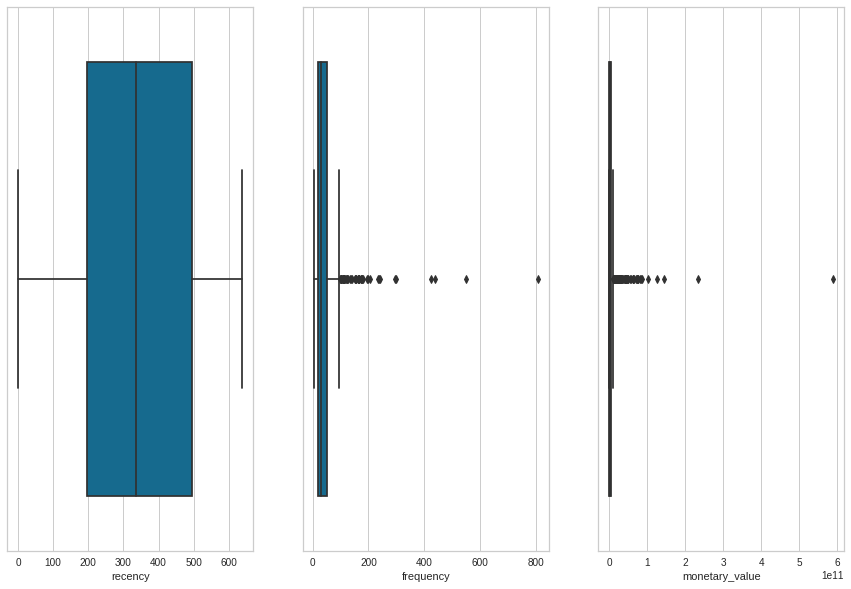

In [ ]:
# analisando outliers
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
sns.boxplot(df_model.recency, orient='h')
plt.subplot(1,3,2)
sns.boxplot(df_model.frequency, orient='h')
plt.subplot(1,3,3)
sns.boxplot(df_model.monetary_value, orient='h')

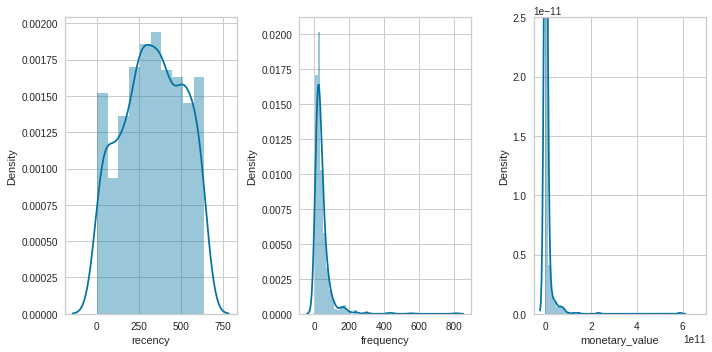

In [ ]:
#analisando distribuição das variáveis
fig, ax = plt.subplots(1, 3, figsize=(10,5))
sns.distplot(df_model.recency, ax=ax[0])
sns.distplot(df_model.frequency, ax=ax[1])
sns.distplot(df_model.monetary_value, ax=ax[2])
ax[2].axis([-0.5e11, 7e11, 0, 25e-12])
plt.tight_layout()
plt.show()

Pode-se ver que a distribuição dos dados das variáveis frequency e monetary value não são normais, o que prejudica a modelagem.

<Figure size 1080x1080 with 0 Axes>

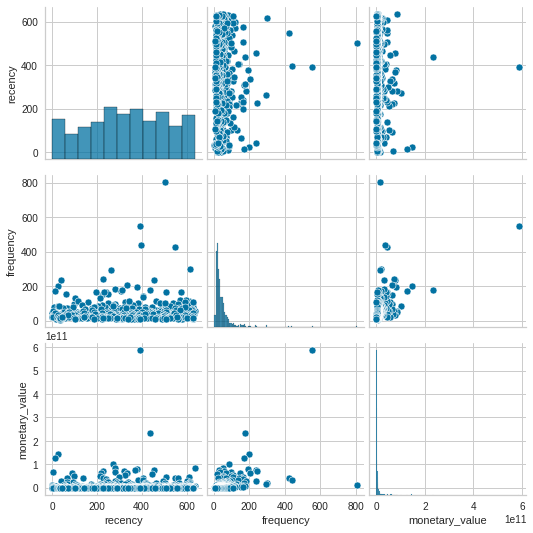

In [ ]:
plt.figure(figsize=(15,15))
sns.pairplot(df_model.drop(columns=['fullVisitorId']))

Aqui, pode-se observar que os clientes estão em sua maioria todos concentrados na região de frequência e valor monetário baixos, exceto alguns poucos outliers que apresentam uma frequência ou um valor moentário maior.

## Modelo basal - K-Means - Dados não transformados

### Escolha do número de clusters - Método do Elbow 

1 35436.84736160119
2 15079.842930546265
3 6150.311559434612
4 4394.812617100161
5 3074.1591562805515
6 2428.965384065221
7 2007.4252837535946
8 1841.5578592572679
9 1766.4738354893516
10 1583.8625562460857


Text(0, 0.5, 'WSS')

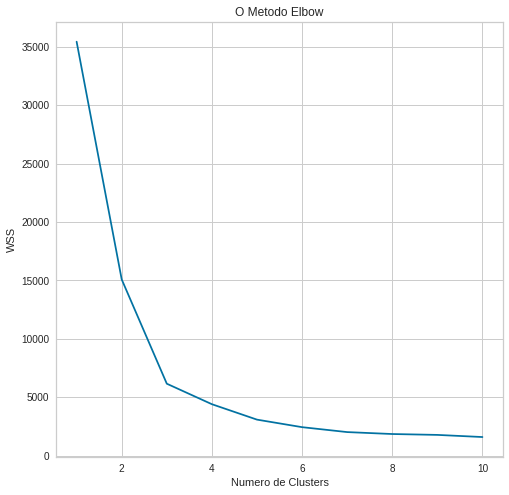

In [ ]:
plt.figure(figsize=(8,8))

# plotando o gráfico do método elbow
wcss = []
 
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'random')
    kmeans.fit(df_robust)
    print (i,kmeans.inertia_)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('O Metodo Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WSS') #within cluster sum of squares

O número de cluster ótimo parece ser igual a 3, pois é o número que mais faz cair a soma do erro quadrático.

### Modelo

In [ ]:
kmeans_basal = KMeans(n_clusters=3)
kmeans_basal = kmeans_basal.fit(df_robust[['recency', 'frequency', 'monetary_value']])
# labels dos clusters
labels = kmeans_basal.predict(df_robust[['recency', 'frequency', 'monetary_value']])
# centroides dos clusters
C = kmeans_basal.cluster_centers_

In [ ]:
df_clusters_basal = df_robust.copy()[['recency', 'frequency', 'monetary_value']]
df_clusters_basal['cluster'] = labels
df_clusters_basal

,recency,frequency,monetary_value,cluster
0,0.190635,16.806452,145.573971,1
1,0.344482,4.709677,57.676860,2
2,-1.040134,5.419355,35.543993,2
3,-1.080268,4.580645,30.732422,2
4,-0.217391,1.774194,24.893929,2
...,...,...,...,...
698,0.581940,-0.677419,-0.364056,0
699,-0.648829,-0.354839,-0.367830,0
700,0.742475,-0.354839,-0.367877,0
701,0.187291,-0.645161,-0.373555,0


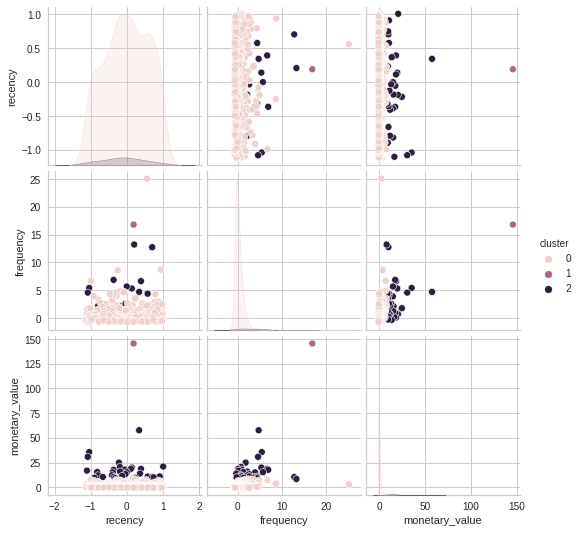

In [ ]:
sns.pairplot(data=df_clusters_basal, hue='cluster')

Como se pode ver, a qualidade da clusterização fica muito ruim sem a transformação dos dados com distribuição não normal, não se conseguindo nem ao mesmo identificar clusters visualmente no conjunto de pontos.

Pode-se ver também que um dos clusters fica totalmente tendencioso para um determinado outlier. Portanto, a seguir é feita uma análise mais aprofundada destes outliers.

## Análise de Outliers

In [ ]:
df_model.describe()

,recency,frequency,monetary_value
count,703.000000,703.000000,7.030000e+02
mean,332.479374,44.389758,7.301097e+09
std,179.075258,54.563030,2.758827e+10
min,1.000000,4.000000,0.000000e+00
25%,197.000000,20.000000,6.884050e+08
50%,336.000000,30.000000,1.617300e+09
75%,496.000000,51.000000,4.723690e+09
max,638.000000,807.000000,5.890498e+11


In [ ]:
# o registro 426 não é representativo e será removido
outlier = df_model[df_model.monetary_value == 0]
outlier

,fullVisitorId,recency,frequency,monetary_value
426,628708827036512143,627,108.0,0.0


In [ ]:
#analisando o último percentil dos dados de frequency e monetary_value
percentil_90_frequency = np.percentile(df_model.frequency, 90)
percentil_90_monetary_value = np.percentile(df_model.monetary_value, 90)
outliers = df_model[df_model.frequency > percentil_90_frequency][df_model.monetary_value > percentil_90_monetary_value]
len(outliers)

35

Qual é a receita trazida pelos outliers em relação ao total?

In [ ]:
# removendo outliers e criando novo dataframe
outliers_index = outliers.index.append(outlier.index)
df_sem_outliers = df_model.drop(outliers_index)
receita_sem_outliers = df_sem_outliers.monetary_value.sum()
receita_total = df_model.monetary_value.sum()
receita_outliers = receita_total - receita_sem_outliers
print('Receita total: ', receita_total)
print('Receita outliers: ', receita_outliers)
print('Receita outliers / Receita total (%): ', receita_outliers/receita_total*100)


Receita total:  5132671280000.0
Receita outliers:  2352684740000.0
Receita outliers / Receita total (%):  45.83743262825902


A receita dos outliers representa quase 50% do total, então não será uma opção removê-los dos dados, pois é justamente estes que trazem valor ao negócio. Será aplicada uma transformação para ajustar a distribuição dos dados para que fique mais próxima a uma normal.

## Transformação BoxCox

In [ ]:
# removendo o valor de receita igual a 0
df_model_sem_outlier = df_model.drop(426)

In [ ]:
# gerando dados transformados
frequency_fitted_data, frequency_fitted_lambda = stats.boxcox(df_model_sem_outlier.frequency)
monetary_value_fitted_data, monetary_value_fitted_lambda = stats.boxcox(df_model_sem_outlier.monetary_value)

Lambda value used for Transformation: -0.3015313797781318


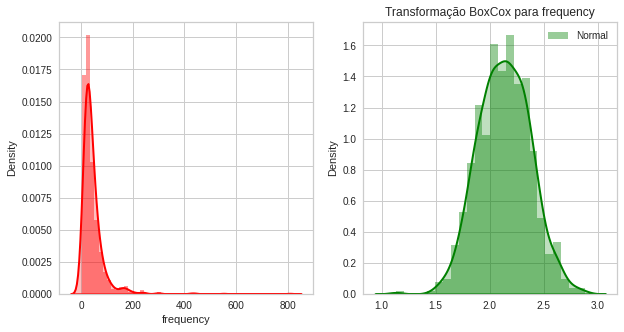

In [ ]:
# plotando dados transformados para frequency
fig, ax = plt.subplots(1, 2)

sns.distplot(df_model.frequency, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Non-Normal", color ="red", ax = ax[0])
  
sns.distplot(frequency_fitted_data, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Normal", color ="green", ax = ax[1])
  
plt.legend(loc = "upper right")
plt.title('Transformação BoxCox para frequency')

fig.set_figheight(5)
fig.set_figwidth(10)
  
print(f"Lambda value used for Transformation: {frequency_fitted_lambda}")

Lambda value used for Transformation: -0.16269058262042527


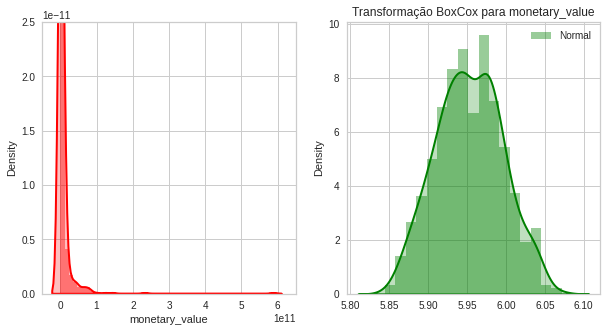

In [ ]:
# plotando dados para monetary_value
fig, ax = plt.subplots(1, 2)

sns.distplot(df_model.monetary_value, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Non-Normal", color ="red", ax = ax[0])
ax[0].axis([-0.5e11, 6.5e11, 0, 25e-12])
  
sns.distplot(monetary_value_fitted_data, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Normal", color ="green", ax = ax[1])
  
plt.legend(loc = "upper right")
plt.title('Transformação BoxCox para monetary_value')

fig.set_figheight(5)
fig.set_figwidth(10)
  
print(f"Lambda value used for Transformation: {monetary_value_fitted_lambda}")

## Novo dataset com distribuição normal das variáveis

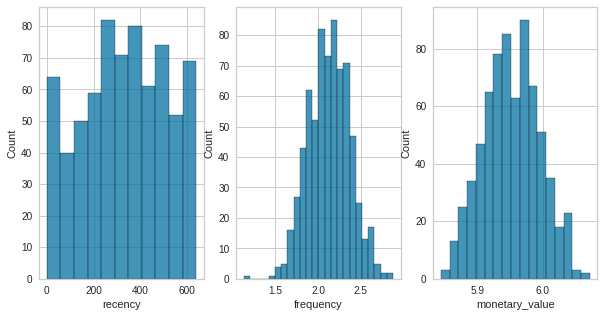

In [ ]:
df_model_transf = df_model_sem_outlier[['fullVisitorId', 'recency']]
df_model_transf['frequency'] = frequency_fitted_data
df_model_transf['monetary_value'] = monetary_value_fitted_data

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
sns.histplot(df_model_transf.recency)
plt.subplot(1,3,2)
sns.histplot(df_model_transf.frequency)
plt.subplot(1,3,3)
sns.histplot(df_model_transf.monetary_value)

### Transformação de escala - RobustScaler

In [ ]:
robust_scaler = RobustScaler()

df_model_transf_robust = robust_scaler.fit_transform(df_model_transf)
df_model_transf_robust = pd.DataFrame(df_model_transf_robust, columns=df_model_transf.columns)

df_model_transf_robust

,fullVisitorId,recency,frequency,monetary_value
0,-0.420121,0.190795,2.102254,1.994031
1,-0.073471,0.344770,1.487732,1.793583
2,-0.233129,-1.041004,1.561375,1.676712
3,0.229275,-1.081172,1.473050,1.639894
4,0.940776,-0.217573,0.969767,1.585143
...,...,...,...,...
697,-0.514154,0.016736,-1.761982,-1.519424
698,0.121756,0.582427,-1.574949,-1.538474
699,-0.727005,-0.649372,-0.531340,-1.623384
700,0.103715,0.743096,-0.531340,-1.624513


## Novo Modelo K-means com dados transformados

### Escolha do número de clusters

1 1168.9661502131225
2 749.236933064233
3 634.0834039374878
4 548.9484510955697
5 494.94391170469726
6 441.122444615378
7 401.7023878618903
8 372.00946200915143
9 350.6005390089527
10 330.2009451510046


Text(0, 0.5, 'WSS')

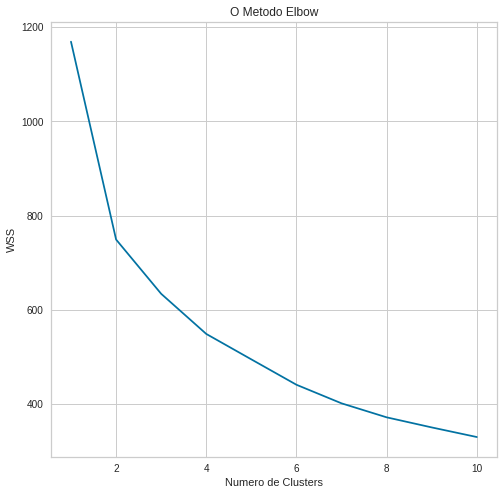

In [ ]:
plt.figure(figsize=(8,8))

# plotando o gráfico do método elbow
wcss = []
 
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'random')
    kmeans.fit(df_model_transf_robust)
    print (i,kmeans.inertia_)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('O Metodo Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WSS') #within cluster sum of squares

Como o método do Elbow sozinho não indica a solução mais apropriada nesse caso, será utilizado em conjunto o método da silhueta.

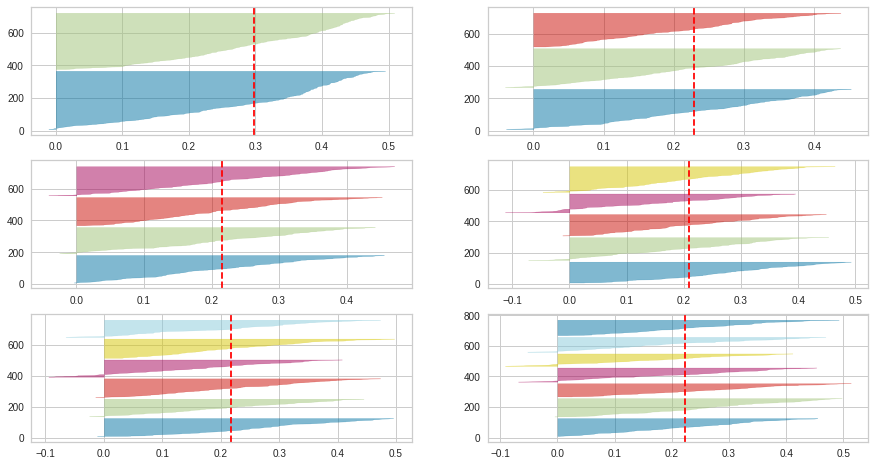

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_model_transf_robust)  

Exceto por alguns poucos dados que podem ter sido designados ao cluster errado, pois ficam muito próximos a outros clusters (coeficiente negativo de silhueta), a combinação dos gráfico do método Elbow e Silhueta indica que um bom número de cluster é igual a 3. Na prática, este também é um número que faz sentido para o negócio, não formando grupos muito grandes nem muito pequenos de clientes.

### Modelo

In [ ]:
kmeans_transf = KMeans(n_clusters=3)
kmeans_transf = kmeans_transf.fit(df_model_transf_robust[['recency', 'frequency', 'monetary_value']])
# labels dos clusters
labels = kmeans_transf.predict(df_model_transf_robust[['recency', 'frequency', 'monetary_value']])
# centroides dos clusters
C = kmeans_transf.cluster_centers_

In [ ]:
df_clusters_transf = df_model_transf_robust.copy()[['recency', 'frequency', 'monetary_value']]
df_clusters_transf['cluster'] = labels
df_clusters_transf

,recency,frequency,monetary_value,cluster
0,0.190795,2.102254,1.994031,1
1,0.344770,1.487732,1.793583,1
2,-1.041004,1.561375,1.676712,1
3,-1.081172,1.473050,1.639894,1
4,-0.217573,0.969767,1.585143,1
...,...,...,...,...
697,0.016736,-1.761982,-1.519424,0
698,0.582427,-1.574949,-1.538474,0
699,-0.649372,-0.531340,-1.623384,0
700,0.743096,-0.531340,-1.624513,0


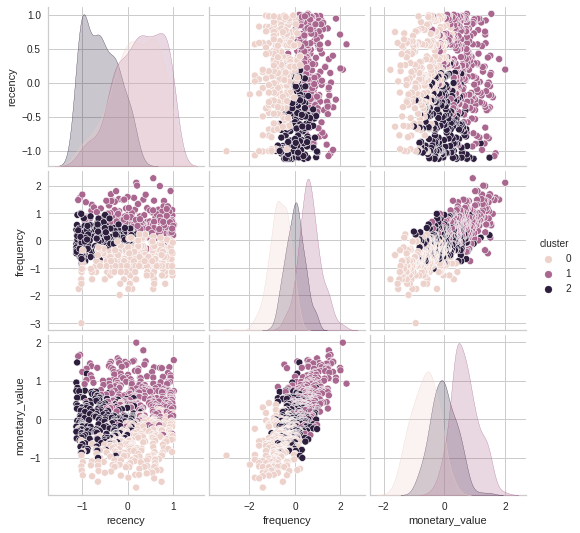

In [ ]:
sns.pairplot(df_clusters_transf, hue='cluster')

Neste caso, pode-se identificar a separação entre os clusters, validando visualmente a segmentação.

Cluster  1
[ 0.17566972 -0.68208235 -0.6413283 ]
Cluster  2
[0.25746918 0.65323542 0.66984621]
Cluster  3
[-0.58554207  0.0072343  -0.02450089]


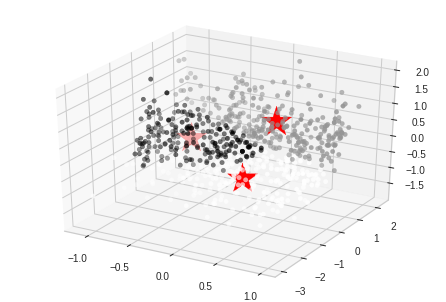

In [ ]:
# plotando os clusters em 3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(df_clusters_transf.recency, df_clusters_transf.frequency, df_clusters_transf.monetary_value, c=labels)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c='red', s=1000)
counter = 1
for cluster in C:
    print('Cluster ',counter)
    print(cluster)
    counter += 1

## Análise dos Clusters

In [ ]:
#dataset para set usado nas análises
df_analise_seg = df_model_sem_outlier.copy()
df_analise_seg['cluster'] = labels
df_analise_seg

,fullVisitorId,recency,frequency,monetary_value,cluster
71,1814166460229302850,393,551.0,5.890498e+11,1
237,3835134197841326255,439,176.0,2.343599e+11,1
162,2904329822175970539,25,198.0,1.450474e+11,1
372,5600144508443168160,13,172.0,1.256314e+11,1
683,9748197746765254389,271,85.0,1.020714e+11,1
...,...,...,...,...,...
33,1265954026564910088,341,8.0,1.519200e+08,0
331,4973306700711399156,510,9.0,1.482300e+08,0
129,25035368390584149,142,19.0,1.330000e+08,0
327,4868132753873877079,558,19.0,1.328100e+08,0


In [ ]:
# construindo dataset de estatisticas dos dados para comparar os valores das médias e dos valores máximos
# de cada uma das variáveis para cada cluster
describe_geral = df_analise_seg.describe().T
describe_cluster_0 = df_analise_seg[df_analise_seg.cluster == 0].describe().T
describe_cluster_1 = df_analise_seg[df_analise_seg.cluster == 1].describe().T
describe_cluster_2 = df_analise_seg[df_analise_seg.cluster == 2].describe().T

# para a media
medias = pd.DataFrame(describe_geral['mean'])
medias['mean_c0'] = describe_cluster_0['mean']
medias['mean_c1'] = describe_cluster_1['mean']
medias['mean_c2'] = describe_cluster_2['mean']
medias.reset_index(inplace=True)
medias = medias[medias['index'] != 'fullVisitorId'][medias['index'] != 'cluster']

# para a quantidade total
count = pd.DataFrame(describe_geral['count'])
count['count_c0'] = describe_cluster_0['count']
count['count_c1'] = describe_cluster_1['count']
count['count_c2'] = describe_cluster_2['count']
count.reset_index(inplace=True)
count = count[count['index'] != 'fullVisitorId'][count['index'] != 'cluster']

# para o valor maximo
max_value = pd.DataFrame(describe_geral['max'])
max_value['max_c0'] = describe_cluster_0['max']
max_value['max_c1'] = describe_cluster_1['max']
max_value['max_c2'] = describe_cluster_2['max']
max_value.reset_index(inplace=True)
max_value = max_value[max_value['index'] != 'fullVisitorId'][max_value['index'] != 'cluster']

In [ ]:
# desagregando os dados para plotar

# para medias
df_melt_medias = pd.melt(medias, id_vars="index", var_name="cluster", value_name="valor_medio")
df_melt_medias
# mudando a escala do monetary_value para ser possivel de visualizar em um mesmo grafico
def muda_escala(valor, feature):
  if feature == 'monetary_value':
    return valor / 10**8
  return valor
df_melt_medias['valor_medio_scaled'] = df_melt_medias.apply(lambda x: muda_escala(x['valor_medio'], x['index']), axis=1)

# para a quantidade total
df_melt_count = pd.melt(count, id_vars="index", var_name="cluster", value_name="count")

# para valores máximos
df_melt_max = pd.melt(max_value, id_vars="index", var_name="cluster", value_name="max")
# mudando a escala do monetary_value para ser possivel de visualizar em um mesmo grafico
df_melt_max['max_scaled'] = df_melt_max.apply(lambda x: muda_escala(x['max'], x['index']), axis=1)

In [ ]:
#como ficou a distribuição dos clusters em relação à quantidade
df_unmelt_count = df_melt_count[df_melt_count['index'] == 'recency']
df_unmelt_count['index'] = ['count']*4
df_unmelt_count

,index,cluster,count
0,count,count,702.0
3,count,count_c0,241.0
6,count,count_c1,259.0
9,count,count_c2,202.0


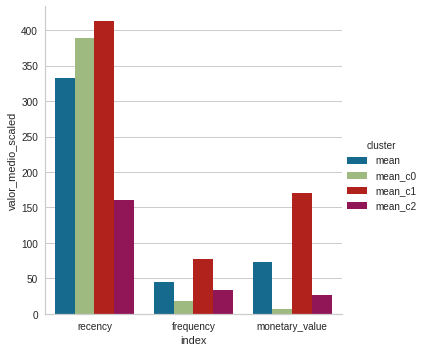

In [ ]:
# valores das médias para cada distribuição de variável, por cluster
sns.catplot(x='index', y='valor_medio_scaled', hue='cluster', data=df_melt_medias[['index', 'cluster', 'valor_medio_scaled']], kind='bar')

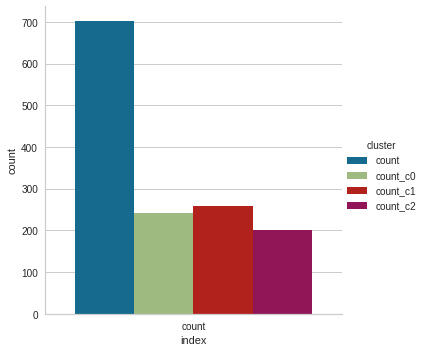

In [ ]:
# valores totais para cada distribuição de variável, por cluster
sns.catplot(x='index', y='count', hue='cluster', data=df_unmelt_count[['index', 'cluster', 'count']], kind='bar')

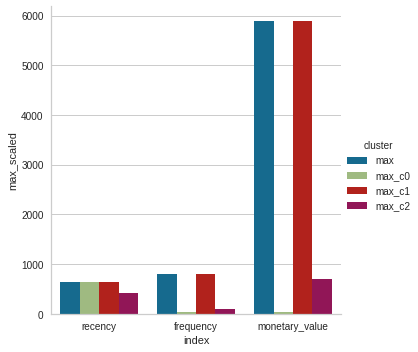

In [ ]:
# valores máximos para cada distribuição de variável, por cluster
sns.catplot(x='index', y='max_scaled', hue='cluster', data=df_melt_max[['index', 'cluster', 'max_scaled']], kind='bar')

**Conclusões:**

Pela análise dos dados, pode-se consluir que os segmentos ficaram aproximadamente com o mesmo número de clientes, sendo o Grupo 2 ligeiramente menor e o Grupo 0 ligeiramente maior. E estas são as características de compra dos segmentos de clientes:
* **Grupo 0**: Clientes que não compram há muitos dias, quando o fizeram compraram pouco (poucas transações) e gastaram pouco no total; 
* **Grupo 1**: Clientes cuja última compra tem as datas mais antigas dos três grupos, mas que representam o maior número médio de transações e também de receita total. Neste grupo está também o cliente que fez o maior número de transações e o que gastou o maior valor monetário do todo.
* **Grupo 2**: Clientes que não compram há menos dias que a média em geral (clientes mais recentes), têm uma frequência de transações aproximadamente igual à média e representam um valor monetário baixo, apenas maior que o do Grupo 0, que é o menos expressivo dos três.

Portanto, quando se trata de campanhas de marketing, a sugestão é que o foco seja em resgatar os clientes do Grupo 1, que compravam com frequência e resultam em valores mais altos no total, e que estão há mais tempo sem o fazer. 

## Trazendo dados completos dos usuários com indicação de clusters

In [ ]:
df_analise_seg_temp = df_analise_seg.copy()
df_analise_seg_temp['fullVisitorIdStr'] = df_analise_seg.fullVisitorId.apply(lambda x: str(x))
usuarios_conversores_temp = usuarios_conversores.copy()
usuarios_conversores_temp['fullVisitorIdStr'] = usuarios_conversores.fullVisitorId.apply(lambda x: str(x))

dados_clientes_completos = df_analise_seg_temp.merge(usuarios_conversores_temp, on=['fullVisitorIdStr'], how='left')
dados_clientes_completos.drop(columns=['fullVisitorIdStr', 'fullVisitorId_y'], inplace=True)
dados_clientes_completos.rename({'fullVisitorId_x': 'fullVisitorId'}, axis=1, inplace=True)
dados_clientes_completos

,fullVisitorId,recency,frequency,monetary_value,cluster,date,visitNumber,visitStartTime,totals_pageviews,totals_newVisits,...,transaction_transactionShipping,transaction_transactionTax,transaction_localTransactionRevenue,transaction_transactionRevenue,localProductPrice,localProductRevenue,productPrice,productQuantity,productRevenue,meanTransactionRevenue
0,1814166460229302850,393,551.0,5.890498e+11,1,20170403,10.0,1.476320e+09,33960.0,47.0,...,76500000.0,0.0,7.073510e+09,7.073510e+09,5.614834e+10,7.073510e+09,5.789551e+10,6492.0,7.073510e+09,1.069056e+09
1,3835134197841326255,439,176.0,2.343599e+11,1,20170216,6.0,1.479404e+09,7158.0,0.0,...,173740000.0,0.0,4.034480e+09,4.034480e+09,1.752439e+10,4.034480e+09,1.813466e+10,3076.0,4.034480e+09,1.331590e+09
2,2904329822175970539,25,198.0,1.450474e+11,1,20180406,36.0,1.510669e+09,3032.0,0.0,...,145630000.0,442480000.0,4.339240e+09,4.339240e+09,9.473712e+09,4.339240e+09,1.010180e+10,2363.0,4.339240e+09,7.325628e+08
3,5600144508443168160,13,172.0,1.256314e+11,1,20180418,13.0,1.524080e+09,4816.0,0.0,...,22000000.0,0.0,1.465830e+09,1.465830e+09,6.858660e+09,1.465830e+09,7.143460e+09,761.0,1.465830e+09,7.304150e+08
4,9748197746765254389,271,85.0,1.020714e+11,1,20170803,12.0,1.501787e+09,5440.0,0.0,...,13990000.0,85920000.0,1.200840e+09,1.200840e+09,2.011905e+10,1.200840e+09,2.035087e+10,976.0,1.200840e+09,1.200840e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,1265954026564910088,341,8.0,1.519200e+08,0,20170525,2.0,1.495741e+09,64.0,0.0,...,9500000.0,5030000.0,1.899000e+07,1.899000e+07,7.995000e+07,1.899000e+07,7.995000e+07,2.0,1.899000e+07,1.899000e+07
698,4973306700711399156,510,9.0,1.482300e+08,0,20161207,5.0,1.481140e+09,81.0,0.0,...,12500000.0,0.0,1.647000e+07,1.647000e+07,4.188000e+07,1.647000e+07,4.188000e+07,8.0,1.647000e+07,1.647000e+07
699,25035368390584149,142,19.0,1.330000e+08,0,20171210,2.0,1.512932e+09,304.0,0.0,...,12000000.0,0.0,7.000000e+06,7.000000e+06,4.558000e+08,7.000000e+06,4.617700e+08,4.0,7.000000e+06,7.000000e+06
700,4868132753873877079,558,19.0,1.328100e+08,0,20161020,2.0,1.476979e+09,304.0,0.0,...,7500000.0,1420000.0,6.990000e+06,6.990000e+06,2.078000e+08,6.990000e+06,2.397600e+08,4.0,6.990000e+06,6.990000e+06


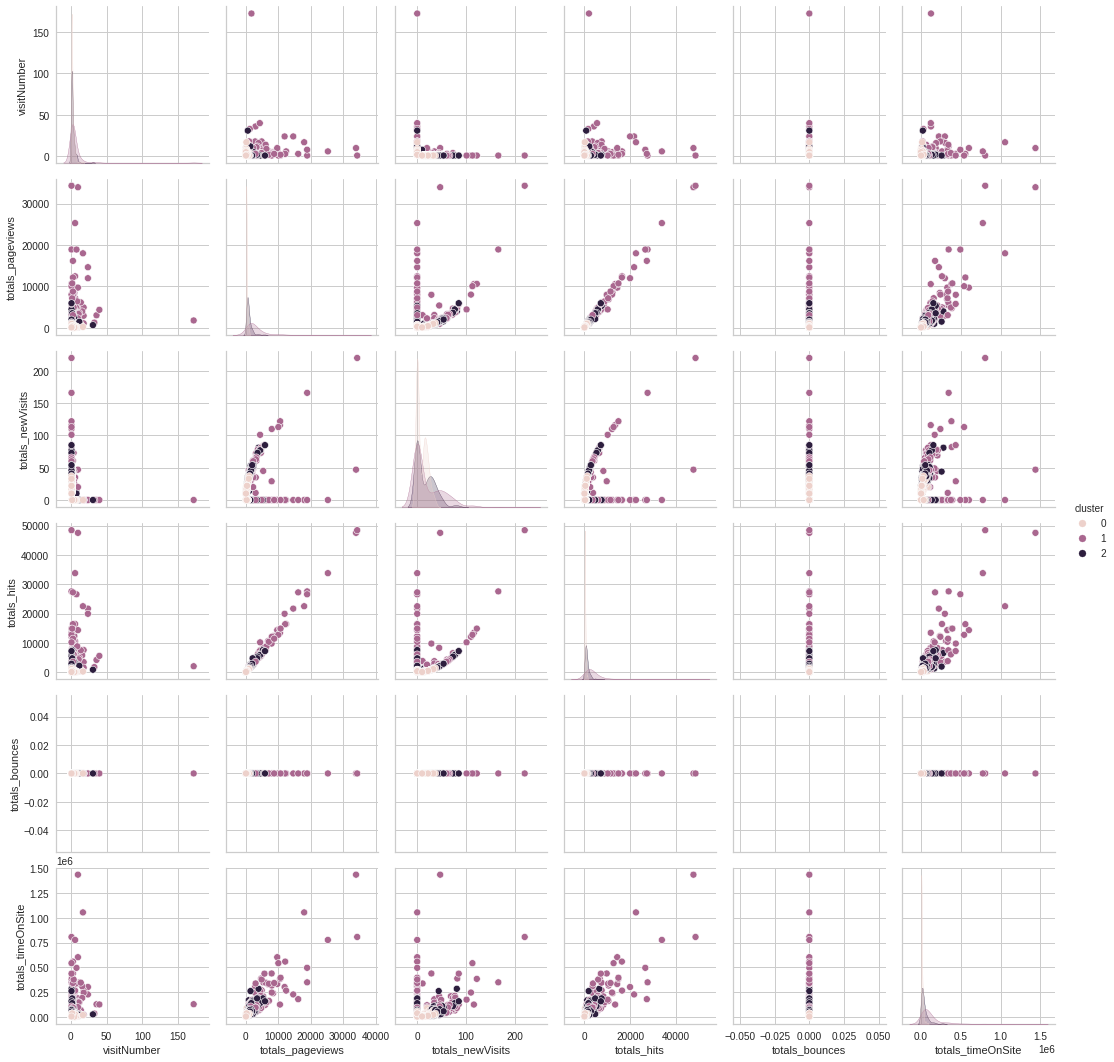

In [ ]:
#quais são as características das sessions para cada grupo de cliente
sns.pairplot(dados_clientes_completos[['cluster', 'date', 'visitNumber', 'totals_pageviews', 
                                       'totals_newVisits', 'totals_hits', 'totals_bounces', 
                                       'totals_timeOnSite']], hue='cluster')

**Conclusões:**

* Quanto maior o número de timeOnSite, maior o número de pageViews ou hits. O grupo que mais passa tempo no site é o 0, seguido pelo 2 e depois pelo 1.
* De modo geral, as visitas bounces (que começam e terminam na mesma página) tem um tempo pequeno de duração. Porém, no grupo 0, este tempo é maior que nos demais, indicando que os usuários do grupo 0 ficam mais tempo em uma sessão sem interação.
* Para visitas que são a primeira do usuário, o total de hits é maior para o grupo 0, seguido pelo grupo 2 e menor para o grupo 1. Ou seja, o novo visitante do grupo 1 não performa muitas interações no site se comparado ao novo visitante do grupo 0.

Em resumo:
* O grupo 1 é o perfil de cliente que entra no site sabendo o que quer, vai direto ao ponto e o faz, sem perder tempo em distrações.
* O grupo 0 é o perfil do usuário curioso, que entra no site para pesquisar, conhecer, não necessariamente para fazer sua compra. 

In [ ]:
#produtos comprados pelos clientes do grupo 0
clientes_0 = dados_clientes_completos[dados_clientes_completos.cluster == 0]
clientes_0['fullVisitorIdStr'] = clientes_0.fullVisitorId.apply(lambda x: str(x))
clientes_0.drop(columns=['fullVisitorId'], inplace=True)
clientes_0.rename({'fullVisitorIdStr': 'fullVisitorId'}, axis=1, inplace=True)
clientes_0
produtos_clientes_0 = clientes_0.merge(products, on=['fullVisitorId'], how='outer')
produtos_clientes_0 = produtos_clientes_0[produtos_clientes_0.localProductRevenue_x > 0]

#produtos comprados pelos clientes do grupo 1
clientes_1 = dados_clientes_completos[dados_clientes_completos.cluster == 1]
clientes_1['fullVisitorIdStr'] = clientes_1.fullVisitorId.apply(lambda x: str(x))
clientes_1.drop(columns=['fullVisitorId'], inplace=True)
clientes_1.rename({'fullVisitorIdStr': 'fullVisitorId'}, axis=1, inplace=True)
clientes_1
produtos_clientes_1 = clientes_1.merge(products, on=['fullVisitorId'], how='outer')
produtos_clientes_1 = produtos_clientes_1[produtos_clientes_1.localProductRevenue_x > 0]

#produtos comprados pelos clientes do grupo 2
clientes_2 = dados_clientes_completos[dados_clientes_completos.cluster == 2]
clientes_2['fullVisitorIdStr'] = clientes_2.fullVisitorId.apply(lambda x: str(x))
clientes_2.drop(columns=['fullVisitorId'], inplace=True)
clientes_2.rename({'fullVisitorIdStr': 'fullVisitorId'}, axis=1, inplace=True)
clientes_2
produtos_clientes_2 = clientes_2.merge(products, on=['fullVisitorId'], how='outer')
produtos_clientes_2 = produtos_clientes_2[produtos_clientes_2.localProductRevenue_x > 0]

Text(0.5, 1.0, 'Produtos - Grupo 2')

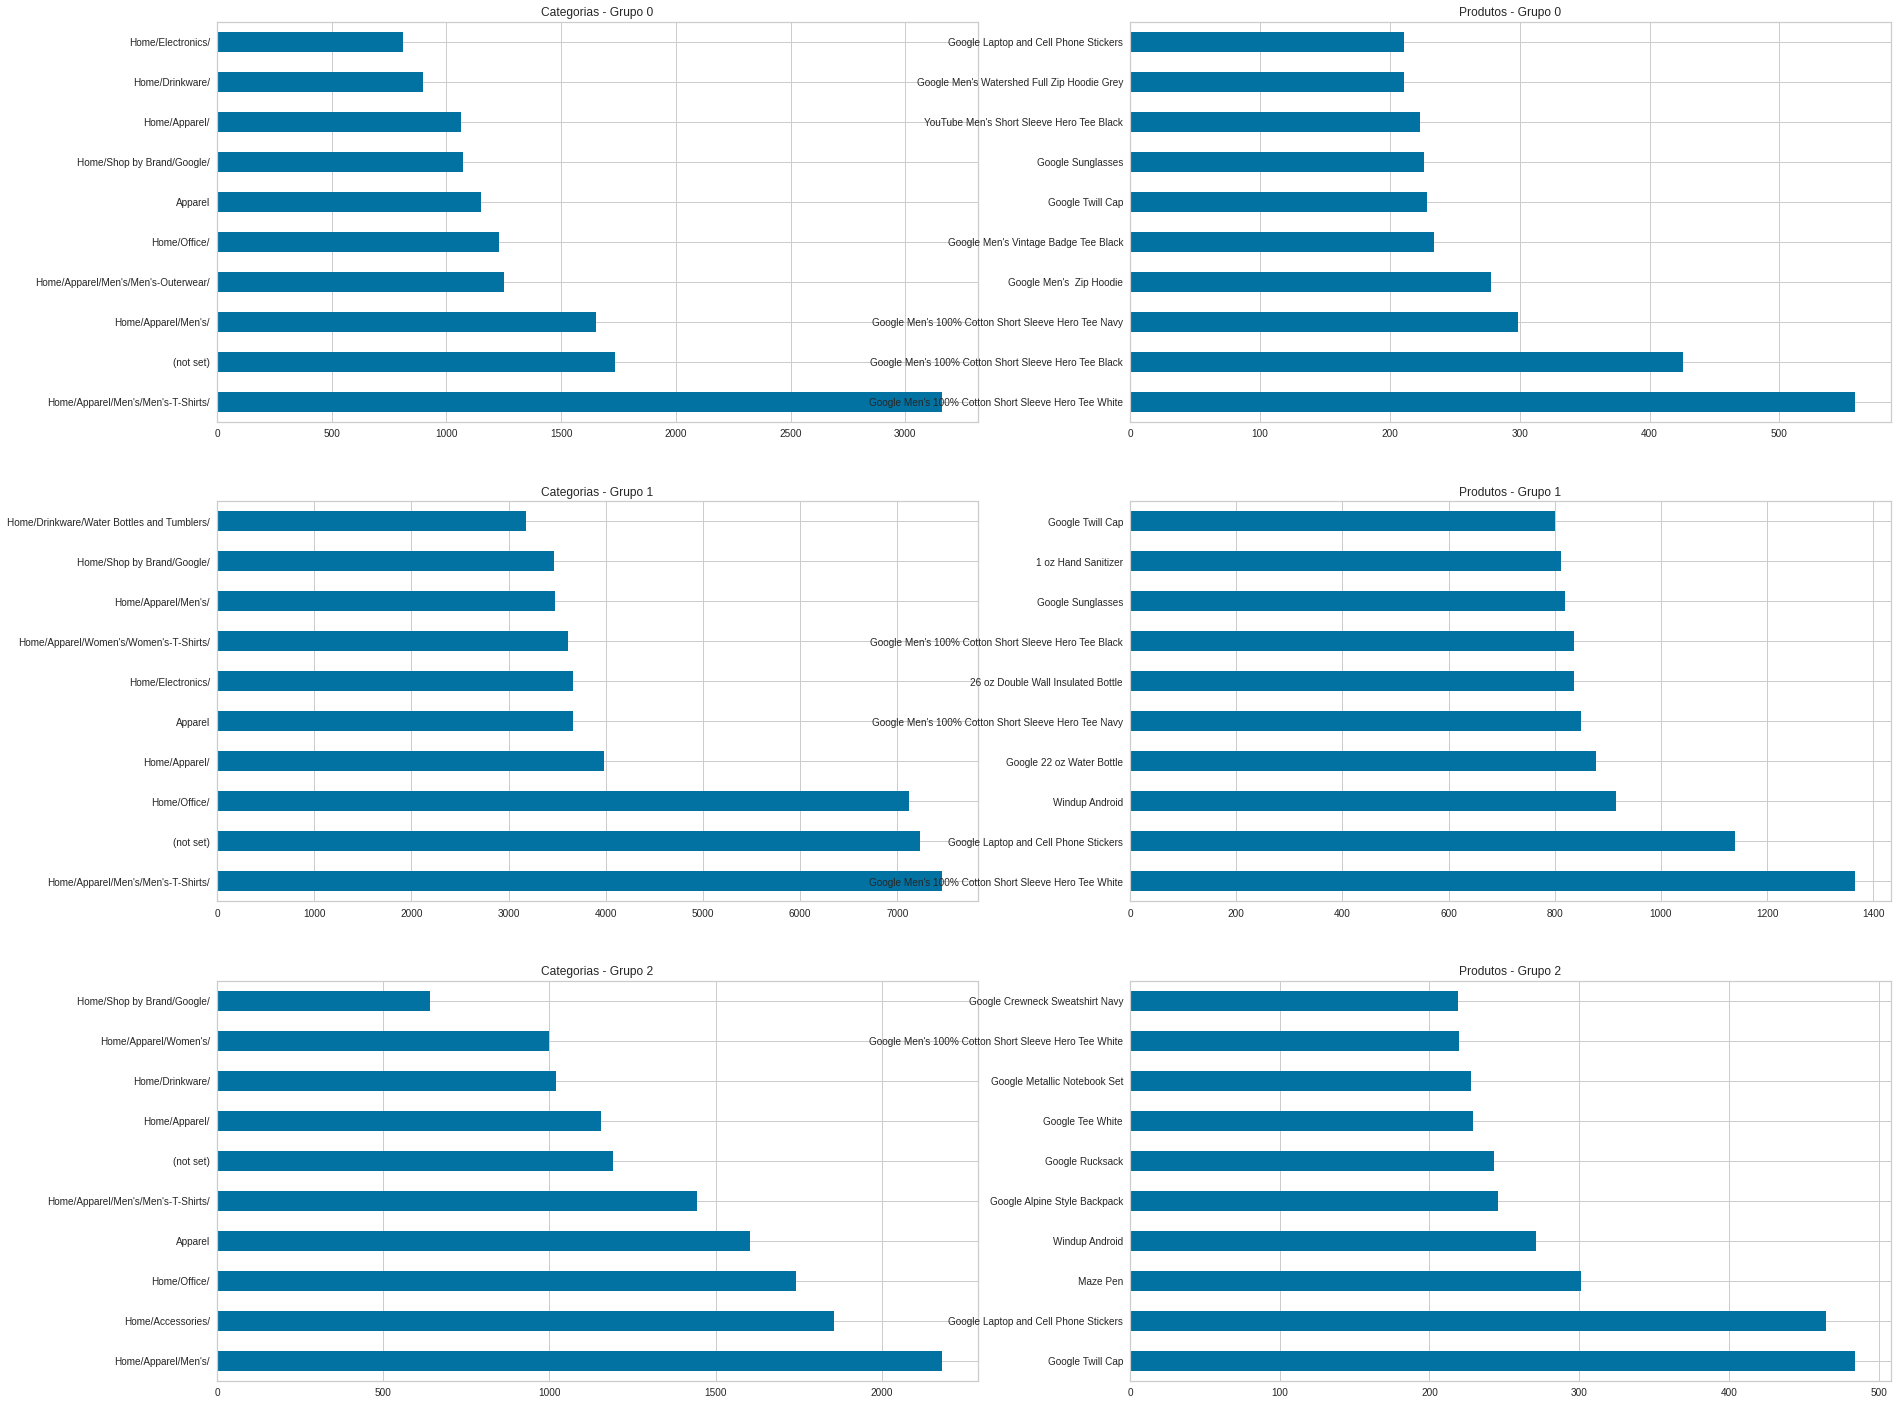

In [ ]:
plt.figure(figsize=(30,25))
plt.subplot(3,2,1)
produtos_clientes_0.v2ProductCategory.value_counts().head(10).plot(kind='barh')
plt.title('Categorias - Grupo 0')
plt.subplot(3,2,2)
produtos_clientes_0.v2ProductName.value_counts().head(10).plot(kind='barh')
plt.title('Produtos - Grupo 0')
plt.subplot(3,2,3)
produtos_clientes_1.v2ProductCategory.value_counts().head(10).plot(kind='barh')
plt.title('Categorias - Grupo 1')
plt.subplot(3,2,4)
produtos_clientes_1.v2ProductName.value_counts().head(10).plot(kind='barh')
plt.title('Produtos - Grupo 1')
plt.subplot(3,2,5)
produtos_clientes_2.v2ProductCategory.value_counts().head(10).plot(kind='barh')
plt.title('Categorias - Grupo 2')
plt.subplot(3,2,6)
produtos_clientes_2.v2ProductName.value_counts().head(10).plot(kind='barh')
plt.title('Produtos - Grupo 2')

Conhecendo os produtos mais comprados por cada um dos três grupos, pode-se criar campanhas direcionadas para cada um deles, além de ofertas inseridas em redes sociais.

# **PARTE 3** - Modelo de propensão de compra

## Racional do problema

* Para criar o modelo de propensão, inicialmente eu criaria uma variável target que classificaria a propensão de compra de cada cliente. Por exemplo, um cliente que poderia ser definido como um comprador provável é aquele que entra no site já com o intuito de fazer a sua compra. Em variáveis, isso poderia ser traduzido como aquele cliente que está fazendo sua primeira visita no site e cujo número de transações é maior que zero. Ou seja, a variável de propensão poderia ser igual a 1 caso o valor de "totals_newVisit" fosse igual a 1 e o valor de "totals_transactions" maior que zero; ou igual a 0 caso alguma dessas duas condições não se verificassem.

* De posse dessa variável, dividiria o dataset em treino e teste e aplicaria algum modelo de classificação para prever o valor da variável de propensão para novos dados que entrassem no dataset. Algumas opções que eu testaria seria a regressão logística e árvores de decisão.

* Finalmente, após ter testado alguns modelos, escolheria o melhor deles com base nas métricas de problemas de classificação, que são a precisão, o recall, ou o F1 score, que é uma combinação dessas duas. Para este problema, o recall é a métrica de maior interesse, pois ele traz a informação do quanto o modelo está conseguindo captar os clientes que seriam bons compradores, ainda que ele cometa erros, mas neste problema os erros não têm alto risco, já que seriam traduzidos, por exemplo, em recomendar um produto errado para um cliente. Já a precisão traria a informação do quanto o modelo está conseguindo acertar as predições que ele faz, o que também é se extrema importância, mas pode ser olhado em um segundo momento. O ideal é ter um F1 score alto, mas na prática sabe-se que isso é difícil algumas vezes.